 
# Leasing Price Predictor
**Data Science Lab**
  - Tobias Ponesch
  - Sina Haghgoo
  - Finnian John Dempsey
  - Adrian Lehrner
---

## Libraries

In [5]:
import pandas as pd
import numpy as np

#Sklearn Preprocessing:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Sklearn model builder:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#XGB model
from xgboost import XGBRegressor

#Sklearn metrics:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

#Model evaluation
import shap
from sklearn.metrics import PredictionErrorDisplay

#from sklearn.preprocessing import FunctionTransformer
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import MinMaxScaler


#from sklearn.preprocessing import OneHotEncoder

#Other helper libraries
from dateutil.relativedelta import relativedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
from joblib import dump, load
import multiprocessing
import psutil
import threading
import time
import os

ModuleNotFoundError: No module named 'xgboost'

In [2]:
#!pip install --upgrade seaborn

---

## Set reference for computational effort

In [139]:
# Just execute this cell
allowed_values = ["ludicrous", "high", "medium", "low"]

comp_effort = input("Enter your computational performance (High, Medium, or Low): ")
comp_effort = comp_effort.lower()

while comp_effort not in allowed_values:
    print("Invalid input. Please try again.")
    comp_effort = input("Enter your computational performance (Ludicrous, High, Medium, or Low): ")
    comp_effort = comp_effort.lower()

# The user input is valid
print("Your computational performance:", comp_effort)

#To ensure machine usability while executing models, we define usable cores
available_cores = multiprocessing.cpu_count()

calc_models = input("If you want to compute the models, enter \"Yes\". If you want to load the existing models, enter \"No\":")
calc_models = calc_models.lower()
allowed=["yes", "no"]
while calc_models not in allowed:
    print("Invalid input. Please try again.")
    calc_models = input("If you want to compute the models, enter \"Yes\". If you want to load the existing models, enter \"No\":")
    calc_models.lower()

if calc_models == "yes":
    compute = True
else:
    compute = False    

Invalid input. Please try again.
Your computational performance: medium


***

## Import the dataset

In [4]:
datafolder = "data"
modelfolder = "models/test"

In [96]:
df = pd.read_excel(f'{datafolder}/dataset_2023.xlsx')
df = df.drop('Unnamed: 0', axis = 1)
df

,brand_name,model_name,milage,first_registration,duration,gear,monthly_fee,emission_value,consumption,horsepower,kilowatts,fuel_type
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",119 g/km,"5,0 l/100 km",150 PS,110 kW,Diesel
1,Volkswagen,T-Cross VW Life TSI,201 km,03/2023,48 Monat (anpassbar),Manuelle Schaltung,"382,58 €",131 g/km,"6,0 l/100 km",95 PS,70 kW,Benzin
2,Seat,Ibiza Austria Edition,15.000 km,10/2022,48 Monat (anpassbar),Manuelle Schaltung,"239,62 €",120 g/km,"5,0 l/100 km",80 PS,59 kW,Benzin
3,Volkswagen,Polo VW,1 km,01/2023,48 Monat (anpassbar),Manuelle Schaltung,"309,11 €",127 g/km,"6,0 l/100 km",80 PS,59 kW,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",138 g/km,"5,0 l/100 km",190 PS,140 kW,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,201 km,01/2023,48 Monat (anpassbar),Automatik,"692,03 €",146 g/km,"6,0 l/100 km",150 PS,110 kW,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",187 g/km,"8,0 l/100 km",150 PS,110 kW,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",143 g/km,"6,0 l/100 km",190 PS,140 kW,Diesel
19056,Volkswagen,Polo VW,18.903 km,06/2020,48 Monat (anpassbar),Manuelle Schaltung,"256,33 €",40 g/km,"2,0 l/100 km",80 PS,59 kW,Benzin


In [97]:
#Enter the actual column names
brand = "brand_name"
model = "model_name"
milage = "milage"
registration = "first_registration"
duration = "duration"
gear = "gear"
fee = "monthly_fee"
emission = "emission_value"
consumption = "consumption"
horsepower = "horsepower"
kilowatts = "kilowatts"
fuel = "fuel_type"

rename_columns = {
    brand:"brand",
    model:"model",
    milage:"milage",
    registration:"registration",
    duration:"duration",
    gear:"gear",
    fee:"fee",
    emission:"emission",
    consumption:"consumption",
    horsepower:"horsepower",
    kilowatts:"kilowatts",
    fuel:"fuel"
}

df = df.rename(columns=rename_columns)
df

,brand,model,milage,registration,duration,gear,fee,emission,consumption,horsepower,kilowatts,fuel
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",119 g/km,"5,0 l/100 km",150 PS,110 kW,Diesel
1,Volkswagen,T-Cross VW Life TSI,201 km,03/2023,48 Monat (anpassbar),Manuelle Schaltung,"382,58 €",131 g/km,"6,0 l/100 km",95 PS,70 kW,Benzin
2,Seat,Ibiza Austria Edition,15.000 km,10/2022,48 Monat (anpassbar),Manuelle Schaltung,"239,62 €",120 g/km,"5,0 l/100 km",80 PS,59 kW,Benzin
3,Volkswagen,Polo VW,1 km,01/2023,48 Monat (anpassbar),Manuelle Schaltung,"309,11 €",127 g/km,"6,0 l/100 km",80 PS,59 kW,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",138 g/km,"5,0 l/100 km",190 PS,140 kW,Diesel
...,...,...,...,...,...,...,...,...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,201 km,01/2023,48 Monat (anpassbar),Automatik,"692,03 €",146 g/km,"6,0 l/100 km",150 PS,110 kW,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,201 km,03/2023,48 Monat (anpassbar),Automatik,"574,01 €",187 g/km,"8,0 l/100 km",150 PS,110 kW,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,105.301 km,12/2019,48 Monat (anpassbar),Automatik,"587,75 €",143 g/km,"6,0 l/100 km",190 PS,140 kW,Diesel
19056,Volkswagen,Polo VW,18.903 km,06/2020,48 Monat (anpassbar),Manuelle Schaltung,"256,33 €",40 g/km,"2,0 l/100 km",80 PS,59 kW,Benzin


In [98]:
SEED = 2023
TARGET_name = "fee"
FEATURE_names = df.drop(TARGET_name, axis=1).columns

***

## First Preprocessing

In [99]:
class CalculateAge(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        pass
    
    def transform(self, X, y=None):
        print(self.columns)
        def calculate_age(registration_date):
            if registration_date == "Neuwagen":
                return 0
            else:
                today = datetime.now()
                date = datetime.strptime(registration_date, "%m/%Y")
                delta = relativedelta(today, date)
                return (delta.years * 12) + delta.months
        Xc = X.copy()
        if self.columns:
            columns = self.columns
        else:
            columns = Xc.columns
        Xc[columns[0]] = Xc[columns[0]].replace(["","nan"], np.nan)
        Xc[columns[0]] = Xc[columns[0]].apply(calculate_age)
        return Xc

class RemoveUnits(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def extractFloats(input):
            try:
                input = input.split(" ")[0]
                f = float(input.replace('.','').replace(',','.'))
                return(f)
            except AttributeError:
                return input        
        
        X_=X.copy()
        columns = X.columns
        X_[columns] = X_[columns].apply(lambda col: col.replace(["","nan"], np.nan))
        X_[columns] = X_[columns].apply(lambda col: col.apply(extractFloats))
        return X_
        
    def get_feature_names_out(self):
        pass
       

In [100]:
units = ["milage", "duration", "fee", "emission", "consumption", "horsepower", "kilowatts"]

basicpreprocessor = ColumnTransformer(
    transformers=[
        ('age', CalculateAge(),["registration"]),
        ('unit', RemoveUnits(),units)
    ],
    remainder = "passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

df = basicpreprocessor.fit_transform(df)
df.head()

None


,registration,milage,duration,fee,emission,consumption,horsepower,kilowatts,brand,model,gear,fuel
0,2,201.0,48.0,574.01,119.0,5.0,150.0,110.0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
1,2,201.0,48.0,382.58,131.0,6.0,95.0,70.0,Volkswagen,T-Cross VW Life TSI,Manuelle Schaltung,Benzin
2,7,15000.0,48.0,239.62,120.0,5.0,80.0,59.0,Seat,Ibiza Austria Edition,Manuelle Schaltung,Benzin
3,4,1.0,48.0,309.11,127.0,6.0,80.0,59.0,Volkswagen,Polo VW,Manuelle Schaltung,Benzin
4,41,105301.0,48.0,587.75,138.0,5.0,190.0,140.0,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel


In [101]:
basicpreprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('age', CalculateAge(), ['registration']),
                                ('unit', RemoveUnits(),
                                 ['milage', 'duration', 'fee', 'emission',
                                  'consumption', 'horsepower', 'kilowatts'])],
                  verbose_feature_names_out=False)

In [102]:
TARGET = pd.DataFrame(df["fee"])
num_FEATURES = df[df.select_dtypes(include=['float64', 'int64']).columns].drop("fee", axis=1)
cat_FEATURES = df[df.select_dtypes(exclude=['float64', 'int64']).columns]

***

## Explanatory Data Analysis

### Traget variable

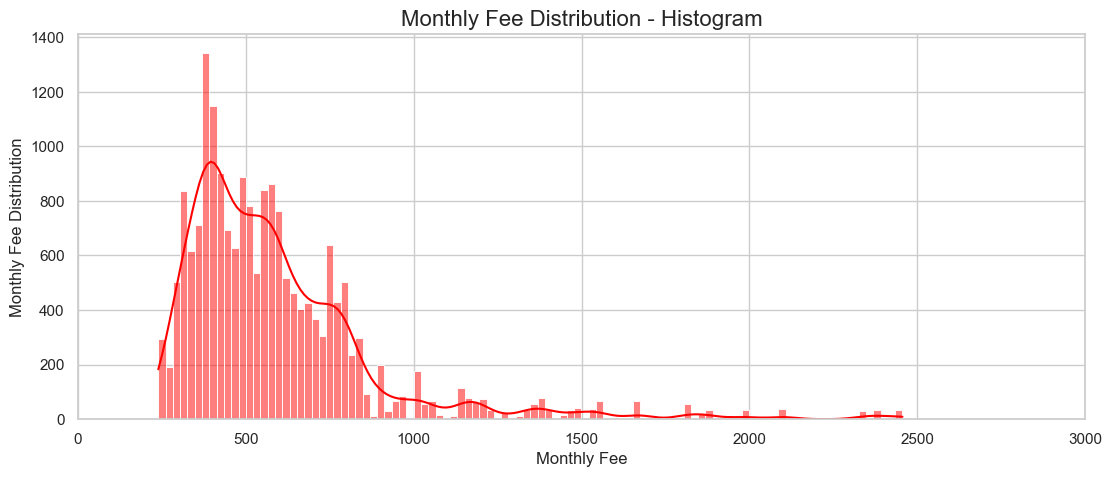

In [103]:
# Histogram
hist_color = 'red'
title_font_size = 16
label_font_size = 12
plt.figure(figsize=(13,5))
sns.histplot(TARGET['fee'], kde=True, color=hist_color)
plt.title('Monthly Fee Distribution - Histogram', fontsize=title_font_size)
plt.xlabel('Monthly Fee', fontsize=label_font_size)
plt.xticks(ticks=plt.xticks()[0][::1])  
plt.ylabel('Monthly Fee Distribution', fontsize=label_font_size)
plt.grid(True)
plt.show()

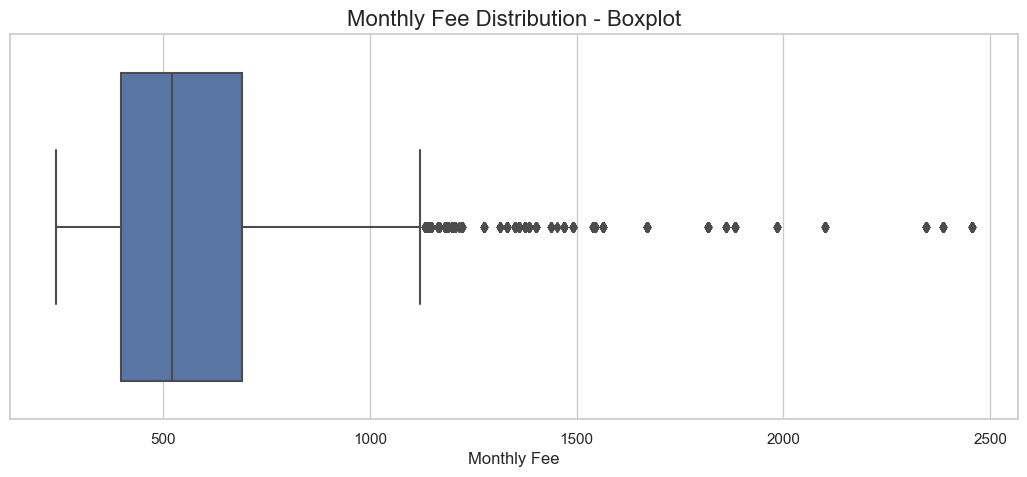

In [104]:
# Boxplot
plt.figure(figsize=(13,5))
sns.boxplot(x=df['fee'])
plt.title('Monthly Fee Distribution - Boxplot', fontsize=title_font_size)
plt.xlabel('Monthly Fee', fontsize=label_font_size)
plt.show()

### Numerical Feature Variables

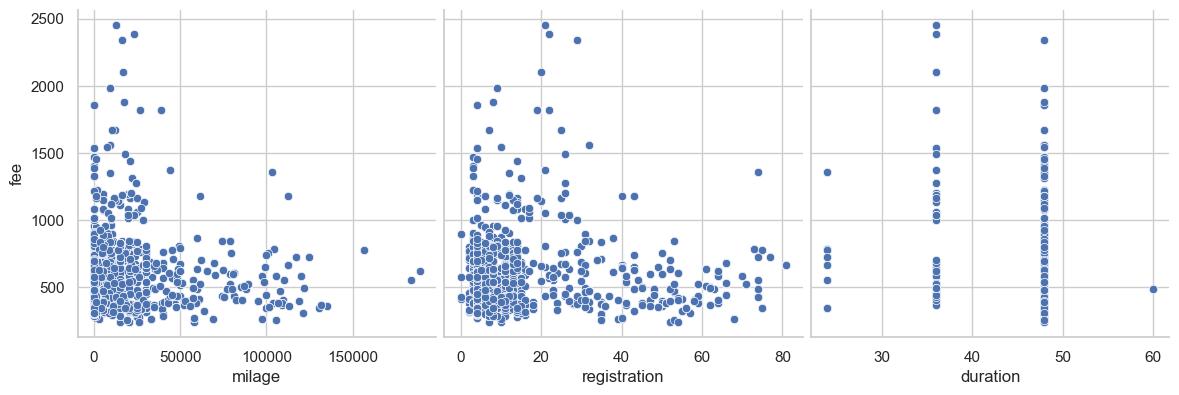

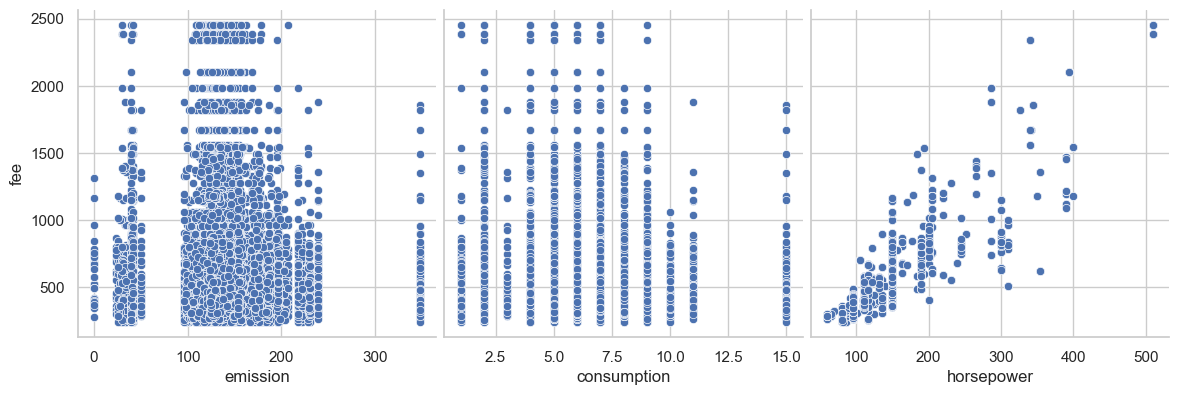

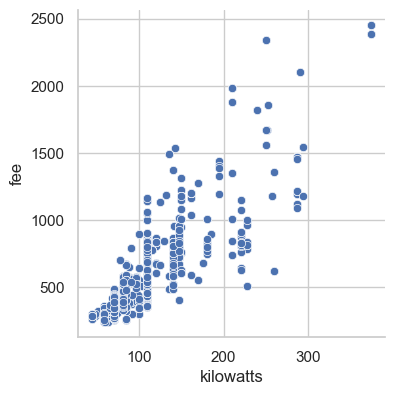

In [105]:
def pp(x,y,z):
    sns.pairplot(df, x_vars=[x,y,z], y_vars='fee',height=4, aspect=1, kind='scatter')
    plt.show()

pp('milage', 'registration', 'duration')
pp('emission', 'consumption', 'horsepower')

def pp(x):
    sns.pairplot(df, x_vars=[x], y_vars='fee',height=4, aspect=1, kind='scatter')
    plt.show()

pp('kilowatts')

#### Skewness of numerical variables

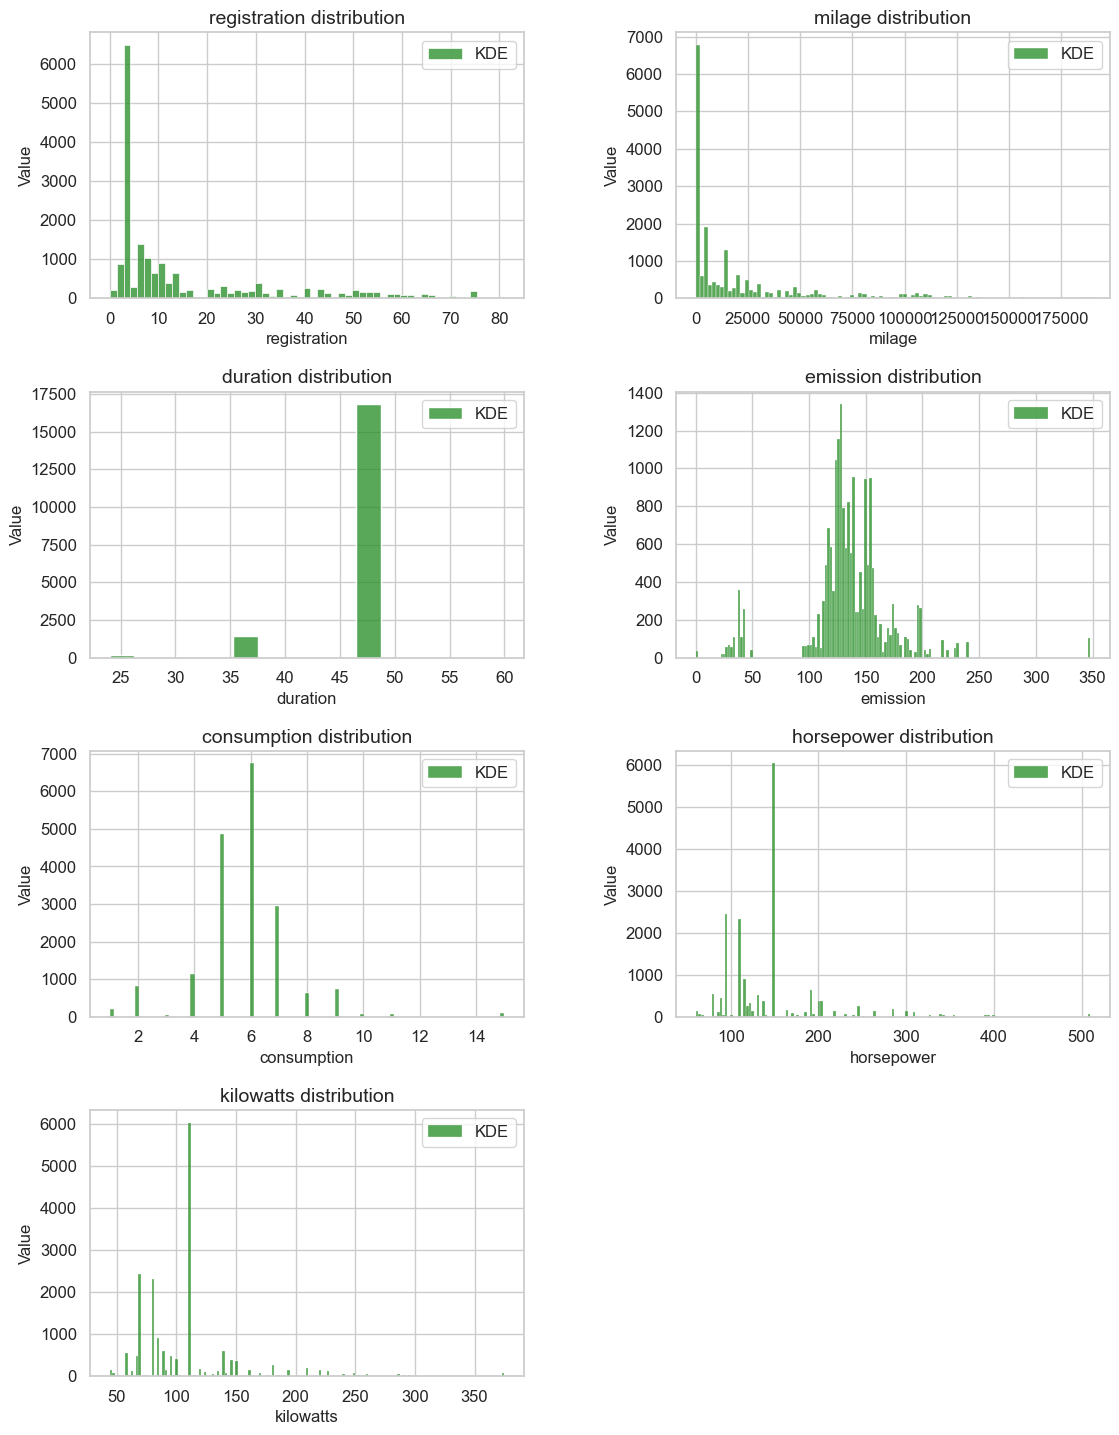

In [106]:
num_FEATURES_hist = num_FEATURES.dropna()

plt.figure(figsize=(12,16))

for i, col in enumerate(num_FEATURES_hist.columns):
    # TAKE A LOOK AT THE IDX VARIABLE!!!!!!
    idx = int('42'+ str(i+1))
    plt.subplot(idx)
    sns.histplot(num_FEATURES_hist[col], color='forestgreen', kde_kws={'color': 'indianred', 'lw': 2, 'label': 'KDE'})
    plt.title(col+' distribution', fontsize=14)
    plt.ylabel('Value', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['KDE'], prop={"size":12})

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
plt.show()

### Categporical Feature Variables

In [107]:
cat_FEATURES

,brand,model,gear,fuel
0,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
1,Volkswagen,T-Cross VW Life TSI,Manuelle Schaltung,Benzin
2,Seat,Ibiza Austria Edition,Manuelle Schaltung,Benzin
3,Volkswagen,Polo VW,Manuelle Schaltung,Benzin
4,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
...,...,...,...,...
19053,Seat,Ateca FR 2.0 TDI DSG 4Drive,Automatik,Diesel
19054,Skoda,Octavia ŠKODA Combi Style TDI DSG,Automatik,Diesel
19055,Audi,A4 Avant 40 TDI quattro S line,Automatik,Diesel
19056,Volkswagen,Polo VW,Manuelle Schaltung,Benzin


Text(0.5, 1.0, 'Gear Frequencies')

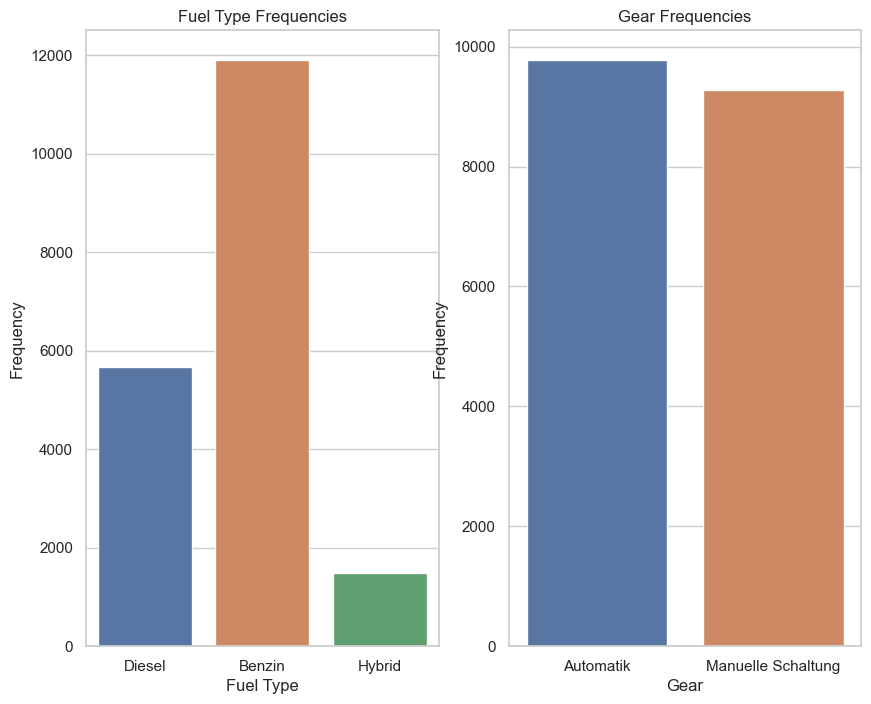

In [108]:
# Create subplots for each categorical variable

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 8))

# Fuel type barplot
sns.countplot(x='fuel', data=cat_FEATURES, ax=axs[0])
axs[0].set_xlabel('Fuel Type')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Fuel Type Frequencies')

# Gear barplot
sns.countplot(x='gear', data=cat_FEATURES, ax=axs[1])
axs[1].set_xlabel('Gear')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Gear Frequencies')

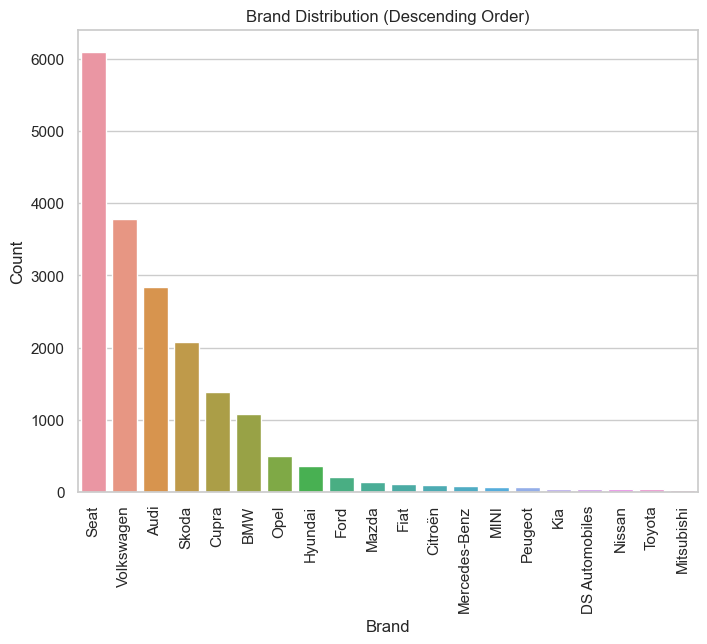

In [109]:
# Distribution of brands
brand_counts = df['brand'].value_counts()

brand_counts = brand_counts.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='brand', order=brand_counts.index)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Brand Distribution (Descending Order)')
plt.xticks(rotation=90)
plt.show()




### Plotting the target variable vs the categorical variables

In [110]:
#### Sina MACHEN

<Figure size 2500x600 with 0 Axes>

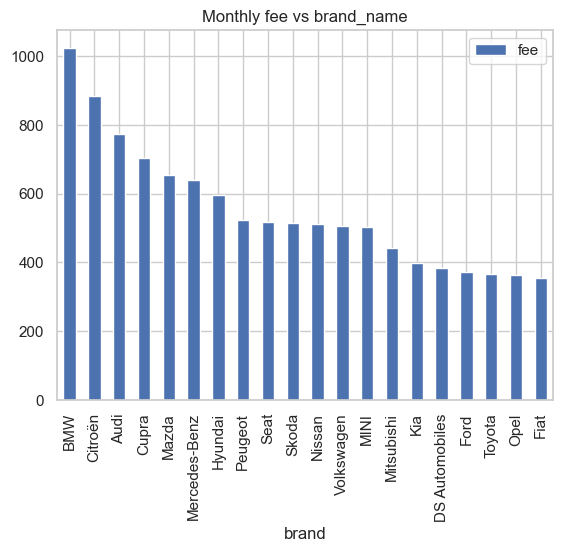

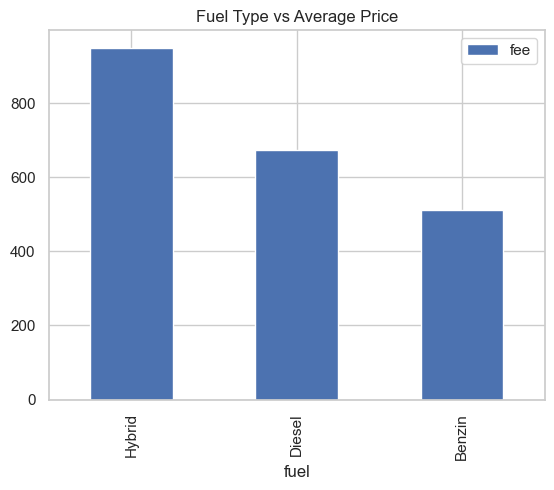

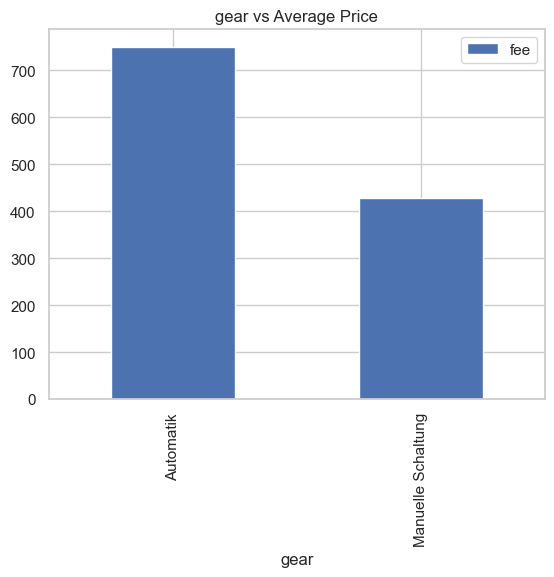

In [111]:
plt.figure(figsize=(25, 6))

df_brand = pd.DataFrame(df.groupby(['brand'])['fee'].mean().sort_values(ascending = False))
df_brand.plot.bar()
plt.title('Monthly fee vs brand_name')
plt.show()

df_fueltype = pd.DataFrame(df.groupby(['fuel'])['fee'].mean().sort_values(ascending = False))
df_fueltype.plot.bar()
plt.title('Fuel Type vs Average Price')
plt.show()

df_gear = pd.DataFrame(df.groupby(['gear'])['fee'].mean().sort_values(ascending = False))
df_gear.plot.bar()
plt.title('gear vs Average Price')
plt.show()

### Heatmap (Correlations)

In [112]:
num_FEATURES

,registration,milage,duration,emission,consumption,horsepower,kilowatts
0,2,201.0,48.0,119.0,5.0,150.0,110.0
1,2,201.0,48.0,131.0,6.0,95.0,70.0
2,7,15000.0,48.0,120.0,5.0,80.0,59.0
3,4,1.0,48.0,127.0,6.0,80.0,59.0
4,41,105301.0,48.0,138.0,5.0,190.0,140.0
...,...,...,...,...,...,...,...
19053,4,201.0,48.0,146.0,6.0,150.0,110.0
19054,2,201.0,48.0,187.0,8.0,150.0,110.0
19055,41,105301.0,48.0,143.0,6.0,190.0,140.0
19056,35,18903.0,48.0,40.0,2.0,80.0,59.0


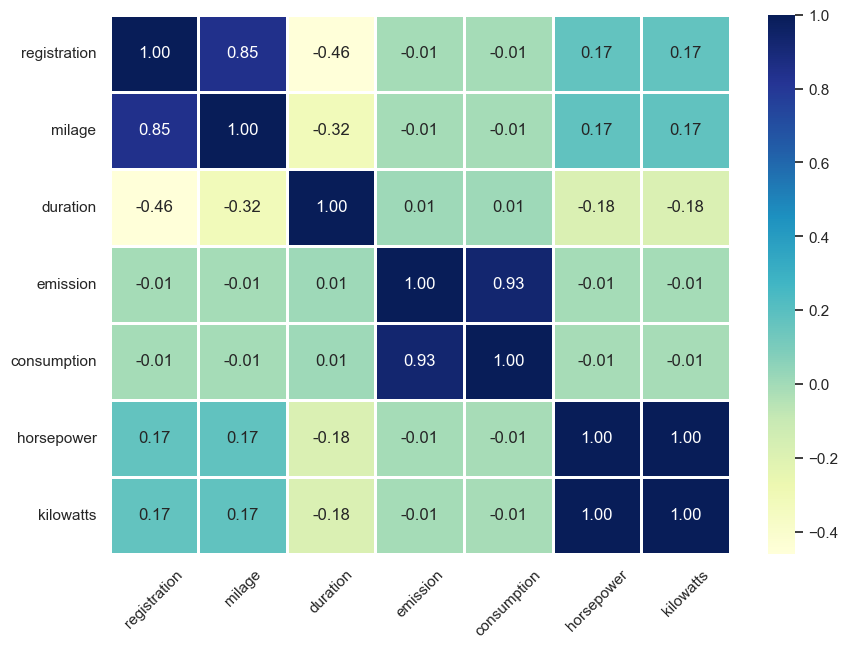

In [113]:
num_corr = num_FEATURES.corr()

# setting figure size
plt.figure(figsize=(10, 7))

# heatmap
sns.heatmap(num_corr, annot=True, linewidths=1.01, fmt=".2f", annot_kws={"size": 12}, linecolor='white', cmap="YlGnBu")

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


### Dropping kilowatts for predictions

In [127]:
df = df.drop('kilowatts', axis = 1)
num_FEATURES = num_FEATURES.drop("kilowatts", axis=1)
FEATURE_names = FEATURE_names.drop("kilowatts")

KeyError: "['kilowatts'] not found in axis"

## Preprocessing and Feature Engineering

### Missing Values


In [115]:
missing_values = df.isnull().sum()

print("Summary of Missing Values:")
print(missing_values)

Summary of Missing Values:
registration      0
milage            0
duration          0
fee               0
emission        612
consumption     612
horsepower        0
brand             0
model             0
gear              0
fuel              0
dtype: int64


### Cardinality of non-numeric features

In [116]:
unique_counts = cat_FEATURES.nunique()
print(unique_counts)

brand     20
model    346
gear       2
fuel       3
dtype: int64


---
### Problems with splitting -- TODO
---

When splitting the dataset by using "train_test_split" we need to use stratification so that one-hot encoding works.
This creates the problem, that entries of the model column, that exist only once OR Twice can not be splitted using stratify. We have three possible approaches:
- drop once or twice appearing single entries of "model"
- duplicate or tripple once or twice appreaing entries of "model"
- create combined category for those models
- **use a custom splitting algorithm**

for now we desided to drop those entries -> Do other approach later!!!!

In [117]:
old_shape = df.shape[0]

In [118]:
few_instances_model = df.groupby("model").filter(lambda x: len(x) < 3)["model"].unique()
df=df[~df["model"].isin(few_instances_model)]
df.shape
print("Models dropped:", old_shape-df.shape[0])

Models dropped: 19


### Out of Sample Dataset

In [119]:
df_sample, df_osample = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df[["model"]])

In [120]:
print("Size of the sample data:",df_sample.shape, "with a mean of: ",df_sample["fee"].mean(),
    "\nSize of out of sample data:",df_osample.shape, "with a mean of: ",df_osample["fee"].mean())

Size of the sample data: (16183, 11) with a mean of:  593.0066569857258 
Size of out of sample data: (2856, 11) with a mean of:  592.3941316526611


### Train and Test slpit

In [121]:
X_sample = df_sample.drop(TARGET_name,axis=1)
Y_sample = df_sample[TARGET_name]

X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.25, random_state=SEED, stratify=X_sample[["model"]])
print("Size of the train data:",X_train.shape,"with a mean fee of:",y_train.mean())
print("Size of the test data:",X_train.shape,"with a mean fee of:",y_test.mean())

Size of the train data: (12137, 10) with a mean fee of: 593.1457435939689
Size of the test data: (12137, 10) with a mean fee of: 592.5894315373208


### Transformer Pipelines

In [133]:
numeric_features = num_FEATURES.columns
categorical_features = cat_FEATURES.columns

In [134]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='error', sparse_output=False, drop = 'first'))])

preprocessor = ColumnTransformer(
    transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)    
    ])

preprocessor.fit(X_train)

cat_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
columns_pipeline = np.append(cat_columns, numeric_features)

## Machine Learning Modeling

### Choosing appropriate metric & customization approach

For evaluation we chose a number of measurements:
- MSE: Mean-Square-Error
- RMSE: Root-Mean-Square-Error (for easier interpretation)
- R-squared (R²)
- Adjusted R-squared
- MAPE: Mean Absolute Percentage Error
- EVS: Explained variance score

#### Monitoring helper function

In [140]:
def monitor_system():
    while monitoring:
        cpu_usage = psutil.cpu_percent()
        memory_usage = psutil.virtual_memory().percent
        cpu_freq = psutil.cpu_freq()
        if isinstance(cpu_freq, list):
            cpu_freq = [f.current for f in cpu_freq]  # Get current frequency for each core
        else:
            cpu_freq = cpu_freq.current  # Get current frequency

        print(f"CPU usage: {cpu_usage}%")
        print(f"Memory usage: {memory_usage}%")
        print(f"CPU clock speed: {cpu_freq} MHz")

        time.sleep(5)  # Sleep for 5 seconds

In [141]:


if comp_effort == "Low":
    crossvals = 3
    iterations = 5 #will be doubled for tree and forest
    cores = available_cores
elif comp_effort =="Medium":
    crossvals = 5
    iterations = 10 #will be doubled for tree and forest
    cores = available_cores -1
elif comp_effort == "High":
    crossvals = 5
    iterations = 15 #will be doubled for tree and forest
    cores = available_cores -1
else:
    crossvals = 10
    iterations = 30
    cores = available_cores -1


def evaluate(model, X, Y):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(Y, y_pred)
    rmse = mse**0.5
    mae = mean_absolute_error(Y, y_pred)
    r2 = r2_score(Y, y_pred)
    evs = explained_variance_score(Y, y_pred)
    mapr = mean_absolute_percentage_error(Y, y_pred)

    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "EVS": evs,
        "MAPE": mapr
    }
    return (metrics)

# Scoring dictionary
scoring1 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}
scoring2 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}
scoring3 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': make_scorer(r2_score),
    'MAPR': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}
scoring4 = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MAPR': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}
scoring = scoring4

### Decision Tree

In [33]:

# Define the parameter distribution
if compute:
    monitoring = True
    start_time = time.time()
    monitoring_thread = threading.Thread(target=monitor_system)
    monitoring_thread.start()
    param_dist = {
        #'regressor__max_depth': randint(1, 10), # increasing depth always increases score -> overfitting
        'regressor__min_samples_split': randint(2, 30),
        'regressor__min_samples_leaf': randint(1, 70),
        'regressor__ccp_alpha': uniform(0, 0.05) # search for best ccp_alpha
    }

    # Create a new pipeline with the decision tree regression model
    decisionTree_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", DecisionTreeRegressor())
    ])

    # Perform randomized search with cross-validation
    decisionTree_randomized_search = RandomizedSearchCV(
        decisionTree_pipeline, 
        param_dist, 
        n_iter=2*iterations, 
        cv=crossvals, 
        scoring=scoring, 
        refit='MSE', 
        random_state=SEED, 
        n_jobs = -1)
    decisionTree_randomized_search.fit(X_train, y_train)

    # evaluation metrics
    train_metrics = evaluate(decisionTree_randomized_search, X_train, y_train)
    test_metrics = evaluate(decisionTree_randomized_search, X_test, y_test)

    # create a dataframe from metrics
    decisionTree_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(decisionTree_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = decisionTree_randomized_search.best_params_

    decisionTree_params = pd.DataFrame({"Parameters": best_params})
    print(decisionTree_params)

    monitoring = False
    monitoring_thread.join()
    end_time = time.time()  # Record the end time
    computation_time = end_time - start_time
    print(f"Computation time: {computation_time}")



In [34]:
if compute:
    finalTree = DecisionTreeRegressor(
        ccp_alpha = best_params['regressor__ccp_alpha'],
        min_samples_leaf = best_params['regressor__min_samples_leaf'],
        min_samples_split = best_params['regressor__min_samples_split']
    )

    decisionTree_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalTree)
    ])
    decisionTree_final.fit(X_train, y_train)
else:
    decisionTree_final = load(f'{modelfolder}/DecisionTreeRegressor.joblib')

train_metrics = evaluate(decisionTree_final, X_train, y_train)
test_metrics = evaluate(decisionTree_final, X_test, y_test)

# create a dataframe from metrics
decisionTree_metrics = pd.DataFrame({'Decision Tree Train':train_metrics, 'Decision Tree Test': test_metrics})

print("\nEvaluation Metrics:")
print(decisionTree_metrics)


Evaluation Metrics:
      Decision Tree Train  Decision Tree Test
MSE             79.107363          101.186923
RMSE             8.894232           10.059171
MAE              3.189123            3.682732
R2               0.999144            0.998909
EVS              0.999144            0.998910
MAPE             0.006018            0.007046


### Random Forest

In [35]:


if compute:
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    param_dist = {
        'regressor__n_estimators': randint(20,50),
        # 'regressor__max_depth': randint(1,7),
        'regressor__min_samples_split': randint(2, 30),
        'regressor__min_samples_leaf': randint(1, 100)
    }

    rf_randomized_search = RandomizedSearchCV(
        rf_pipeline, 
        param_distributions=param_dist, 
        n_iter = 2*iterations, 
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        n_jobs = -1)

    rf_randomized_search.fit(X_train, y_train)

    # evaluation metrics
    train_metrics = evaluate(rf_randomized_search, X_train, y_train)
    test_metrics = evaluate(rf_randomized_search, X_test, y_test)

    # create a dataframe from metrics
    randomForest_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(randomForest_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = rf_randomized_search.best_params_

    randomForest_params = pd.DataFrame({"Parameters": best_params})
    print(randomForest_params)



In [37]:
if compute:
    finalForest = RandomForestRegressor(
        n_estimators = best_params['regressor__n_estimators'],
        min_samples_split = best_params['regressor__min_samples_split'],
        min_samples_leaf = best_params['regressor__min_samples_leaf']
    )

    randomForest_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalForest)
    ])
    randomForest_final.fit(X_train, y_train)

else:
    randomForest_final = load(f'{modelfolder}/RandomForestRegressor.joblib')

train_metrics = evaluate(randomForest_final, X_train, y_train)
test_metrics = evaluate(randomForest_final, X_test, y_test)

# create a dataframe from metrics
randomForest_metrics = pd.DataFrame({'Random Forest Train':train_metrics, 'Random Forest Test': test_metrics})

print("\nEvaluation Metrics:")
print(randomForest_metrics)


Evaluation Metrics:
      Random Forest Train  Random Forest Test
MSE             37.251613           74.095298
RMSE             6.103410            8.607863
MAE              2.107848            2.990922
R2               0.999597            0.999201
EVS              0.999597            0.999202
MAPE             0.003967            0.005743


### K-nearest neighbor

In [142]:


if compute:
# Define the KNN pipeline
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor())
    ])

    # Define the parameter distribution for random search
    param_dist = {
        'regressor__n_neighbors': randint(10, 30),
        'regressor__leaf_size':randint(1,50),
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
    }

    # Perform random search for hyperparameter tuning
    knn_randomized_search = RandomizedSearchCV(
        knn_pipeline,
        param_distributions=param_dist,
        n_iter=2*iterations,
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state = SEED,
        n_jobs = -1
    )

    # Fit the KNN model to the training data
    knn_randomized_search.fit(X_train, y_train)

    # Evaluate the model performance
    train_metrics = evaluate(knn_randomized_search, X_train, y_train)
    test_metrics = evaluate(knn_randomized_search, X_test, y_test)

    # Create a dataframe from metrics
    knn_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(knn_metrics)

    # Get the best hyperparameter values and model performance
    best_params = knn_randomized_search.best_params_
    knn_params = pd.DataFrame({"Parameters": best_params})
    print(knn_params)

    print("\nEvaluation Metrics:")
    print(knn_metrics)

In [39]:
if compute:
    finalKnn = KNeighborsRegressor(
        n_neighbors = best_params['regressor__n_neighbors'],
        weights= best_params['regressor__weights'],
        p = best_params['regressor__p']
    )

    knn_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalKnn)
    ])

    knn_final.fit(X_train, y_train)

else:
    knn_final = load(f'{modelfolder}/KNeighborsRegressor.joblib')


train_metrics = evaluate(knn_final, X_train, y_train)
test_metrics = evaluate(knn_final, X_test, y_test)

# create a dataframe from metrics
knn_metrics = pd.DataFrame({'KNN Train':train_metrics, 'KNN Test': test_metrics})

print("\nEvaluation Metrics:")
print(knn_metrics)


Evaluation Metrics:
      KNN Train    KNN Test
MSE   11.791597  428.254492
RMSE   3.433889   20.694311
MAE    0.702591    8.237974
R2     0.999872    0.995383
EVS    0.999872    0.995386
MAPE   0.001377    0.015046


### XGB

In [40]:

if compute:
    # Define the parameter distribution
    param_dist = {
        'regressor__max_depth': randint(3, 200),
        'regressor__learning_rate': [0.001, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'regressor__n_estimators': randint(100, 500),
        'regressor__gamma': [0.001,  0.01, 0.1, 0.2 , 0.3, 0.4, 0.50],
        'regressor__subsample': [0.5, 0.7, 0.8, 0.9],
        'regressor__colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9],
    }

    # Create a new pipeline with the XGBoost regressor model
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor())
    ])

    # Perform randomized search with cross-validation
    xgb_randomized_search = RandomizedSearchCV(
        xgb_pipeline,
        param_dist,
        n_iter=iterations,
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=-1)
        
    xgb_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics = evaluate(xgb_randomized_search, X_train, y_train)
    test_metrics = evaluate(xgb_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    xgb_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(xgb_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = xgb_randomized_search.best_params_
    xgb_params = pd.DataFrame({"Parameters": best_params})
    print(xgb_params)

In [41]:
if compute:
    finalXGB = XGBRegressor(
        colsample_bytree = best_params['regressor__colsample_bytree'],
        gamma = best_params['regressor__gamma'],
        learning_rate = best_params['regressor__learning_rate'],
        max_depth = best_params['regressor__max_depth'],
        subsample = best_params['regressor__subsample']
    )

    xgb_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalXGB)
    ])
    xgb_final.fit(X_train, y_train)

else:
    xgb_final = load(f'{modelfolder}/XGBRegressor.joblib')

train_metrics = evaluate(xgb_final, X_train, y_train)
test_metrics = evaluate(xgb_final, X_test, y_test)

# Create a DataFrame from metrics
xgb_metrics = pd.DataFrame({'XGB Train': train_metrics, 'XGB Test': test_metrics})

print("\nEvaluation Metrics:")
print(xgb_metrics)


Evaluation Metrics:
      XGB Train   XGB Test
MSE   12.967564  83.684338
RMSE   3.601050   9.147914
MAE    1.109263   3.320201
R2     0.999860   0.999098
EVS    0.999860   0.999101
MAPE   0.002158   0.006516


### Support-Vector-Machines (SVM)

In [42]:


if compute:
    svm_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ])

    param_dist = {
        'regressor__C': [0.01, 0.1, 0.5, 1, 10],
        'regressor__kernel': ['linear', 'rbf', 'poly'],
        'regressor__gamma': ['scale', 'auto'],
        'regressor__epsilon': [0.1, 0.2, 0.3],
    }
    svm_randomized_search = RandomizedSearchCV(
        svm_pipeline,
        param_distributions=param_dist,
        n_iter=iterations,
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=-1
        
    )

    svm_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics = evaluate(svm_randomized_search, X_train, y_train)
    test_metrics = evaluate(svm_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    svm_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(svm_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = svm_randomized_search.best_params_
    svm_params = pd.DataFrame({"Parameters": best_params})
    print(svm_params)

In [43]:
if compute:
    finalSVM = SVR(
        C=best_params['regressor__C'],
        kernel=best_params['regressor__kernel'],
        gamma=best_params['regressor__gamma'],
        epsilon=best_params['regressor__epsilon']
    )

    svm_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalSVM)
    ])
    svm_final.fit(X_train, y_train)

else:
    svm_final = load(f'{modelfolder}/SVR.joblib')

train_metrics = evaluate(svm_final, X_train, y_train)
test_metrics = evaluate(svm_final, X_test, y_test)

# Create a DataFrame from metrics
svm_metrics = pd.DataFrame({'SVM Train': train_metrics, 'SVM Test': test_metrics})

print("\nEvaluation Metrics:")
print(svm_metrics)



Evaluation Metrics:
        SVM Train     SVM Test
MSE   4049.370135  4187.185595
RMSE    63.634661    64.708466
MAE     22.095151    23.260872
R2       0.956188     0.954858
EVS      0.956637     0.955381
MAPE     0.033361     0.035704


## Performance on Test Dataset

### Metrics Plots

In [59]:
metrics = [decisionTree_metrics, randomForest_metrics, knn_metrics, xgb_metrics, svm_metrics]

# Create empty DataFrames for train metrics and test metrics
train_metrics = pd.DataFrame()
test_metrics = pd.DataFrame()

# Loop through the metrics list and assign train and test metrics to respective DataFrames
for metric in metrics:
    for col in metric.columns:
        if "Train" in col:
            train_metrics = pd.concat([train_metrics, metric[[col]]], axis=1)
        elif "Test" in col:
            test_metrics = pd.concat([test_metrics, metric[[col]]], axis=1)

In [62]:
def plotBars(metrics_input):
    #Define the evaluation metrics and their values
    metrics = metrics_input.index
    models = metrics_input.columns
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']

    # Set the figure size and create subplots
    fig, axs = plt.subplots(len(metrics) // 3, 3, figsize=(15, 6 * (len(metrics) // 3)))

    # Set the width of the bars
    bar_width = 0.25

    # Set the positions of the bars on the x-axis

    test_r = np.arange(len(models))
    # train_r = np.arange(len(models))
    # test_r = [x + bar_width/2 for x in r1]
    # Create a bar plot for each evaluation metric
    for i, metric in enumerate(metrics):
        test_values = None
        test_values = metrics_input.loc[metric].values


        # Check if values exist for all models
        if test_values.any() and len(test_values) == len(models):
            row = i // 3  # Determine the row index
            col = i % 3   # Determine the column index
            
            ax = axs[row, col]  # Get the corresponding subplot
            
            # Create a bar plot for each model with different color
            for j in range(len(test_values)):

                # ax.bar(train_r[j], train_values[j], width=bar_width, edgecolor='black', color=colors[j])
                ax.bar(test_r[j], test_values[j], width=bar_width, edgecolor='black', color=colors[j])
                
            
            # Set the labels, title, and ticks for the subplot
            ax.set_xlabel('Model')
            ax.set_ylabel(metric)
            ax.set_title(f'{metric} Comparison')
            ax.set_xticks(test_r)
            ax.set_xticklabels(models.str.strip(" Test"))

            # Adjust the spacing for long x-axis tick labels
            ax.set_xticks(test_r)
            ax.set_xticklabels(models.str.strip(" Test"), rotation=45, ha='right')
            plt.subplots_adjust(bottom=0.5)  # Increase the bottom margin if needed
            # Rotating the x-axis tick labels by 45 degrees for each subplot
            #ax.tick_params(axis='x', rotation=45)

            # Scale the y-axis to better visualize differences
            max_value = np.max(test_values)
            min_value = np.min(test_values)
            ax.set_ylim([min_value - 0.1 * abs(max_value), max_value + 0.1 * abs(max_value)])

            
        
    # Adjust the spacing between subplots
    plt.tight_layout()



    # Show the plot
    plt.show()

In [65]:
train_metrics


,Decision Tree Test,Random Forest Test,KNN Test,XGB Test,SVM Test
MSE,101.186923,74.095298,428.254492,83.684338,4187.185595
RMSE,10.059171,8.607863,20.694311,9.147914,64.708466
MAE,3.682732,2.990922,8.237974,3.320201,23.260872
R2,0.998909,0.999201,0.995383,0.999098,0.954858
EVS,0.998910,0.999202,0.995386,0.999101,0.955381
MAPE,0.007046,0.005743,0.015046,0.006516,0.035704


In [61]:
test_metrics

,Decision Tree Train,Random Forest Train,KNN Train,XGB Train,SVM Train
MSE,79.107363,37.251613,11.791597,12.967564,4049.370135
RMSE,8.894232,6.103410,3.433889,3.601050,63.634661
MAE,3.189123,2.107848,0.702591,1.109263,22.095151
R2,0.999144,0.999597,0.999872,0.999860,0.956188
EVS,0.999144,0.999597,0.999872,0.999860,0.956637
MAPE,0.006018,0.003967,0.001377,0.002158,0.033361


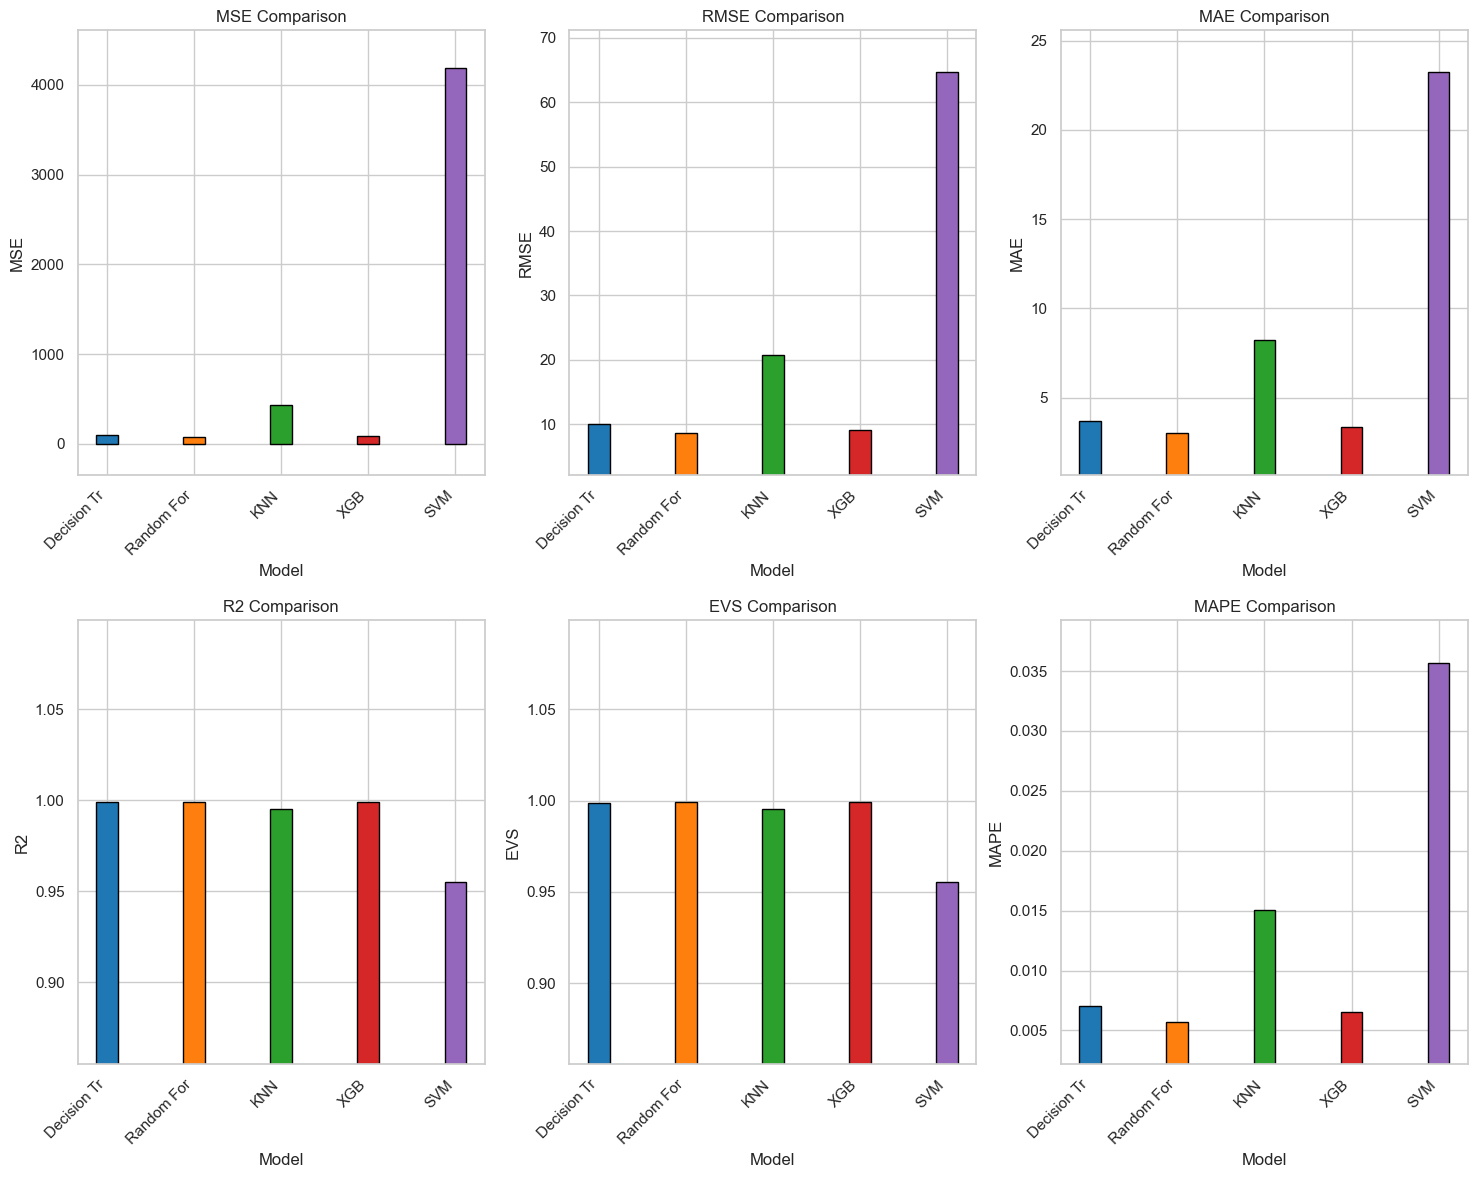

In [63]:
plotBars(test_metrics)

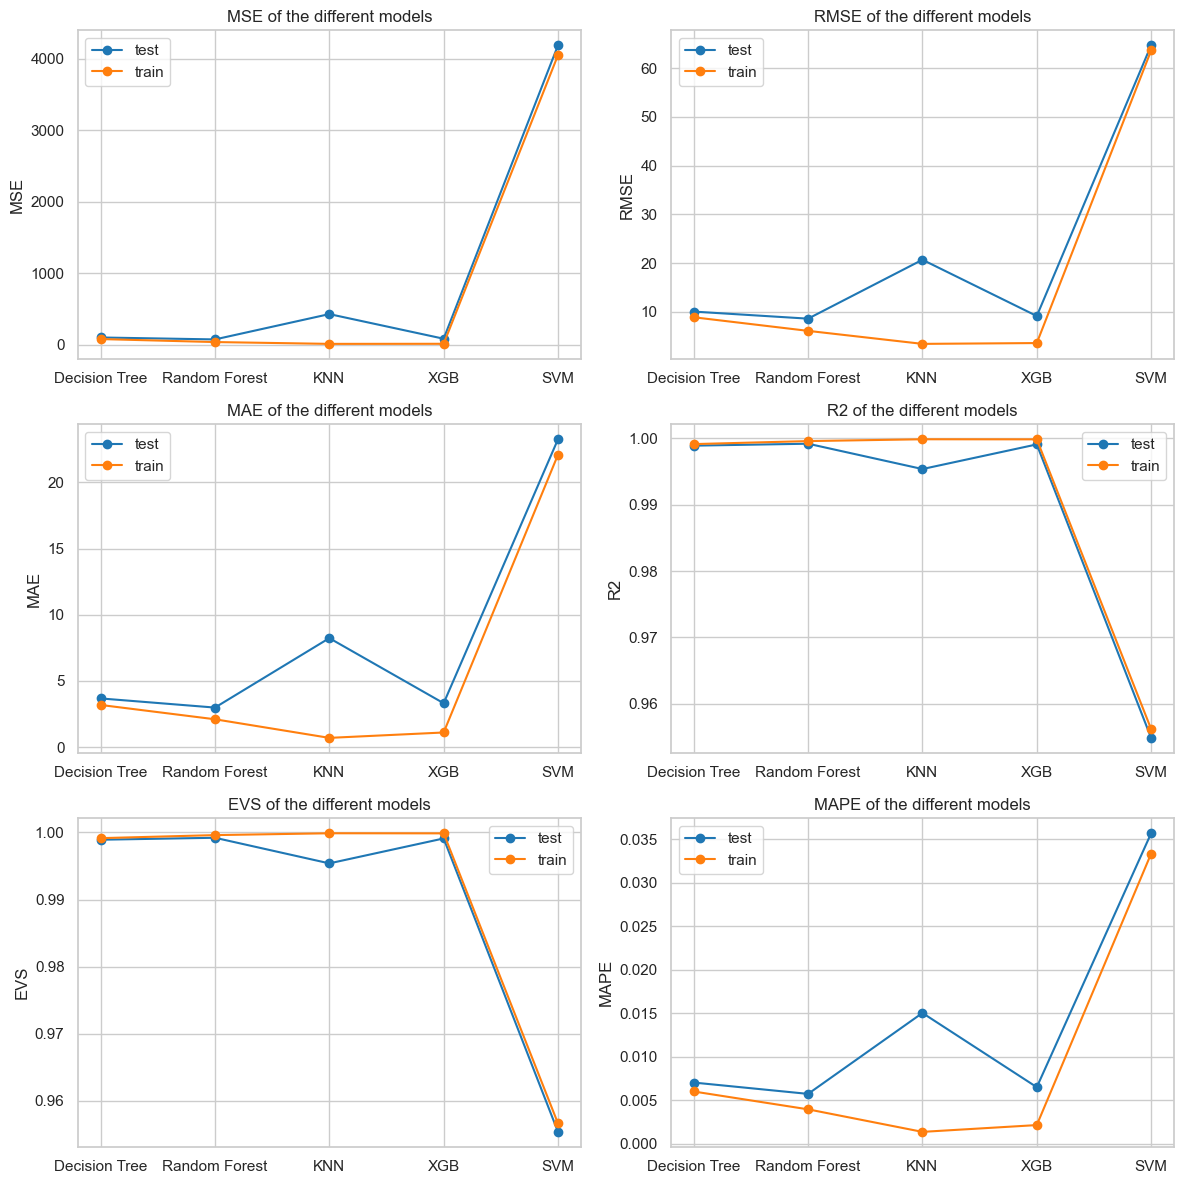

In [66]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e']

# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = test_metrics.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(test_metrics.columns.str.replace(" Test",""), test_metrics.iloc[i], label="test", marker='o', color=colors[0])
    plt.plot(train_metrics.columns.str.replace(" Train",""), train_metrics.iloc[i], label="train", marker='o', color=colors[1])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### Predicted vs actual plots
This is a scatter plot where the x-axis is the actual target values and the y-axis is the predicted values. If your model is perfectly accurate, all the points will lie along the line y = x (a 45-degree line). Deviations from this line indicate errors in prediction.

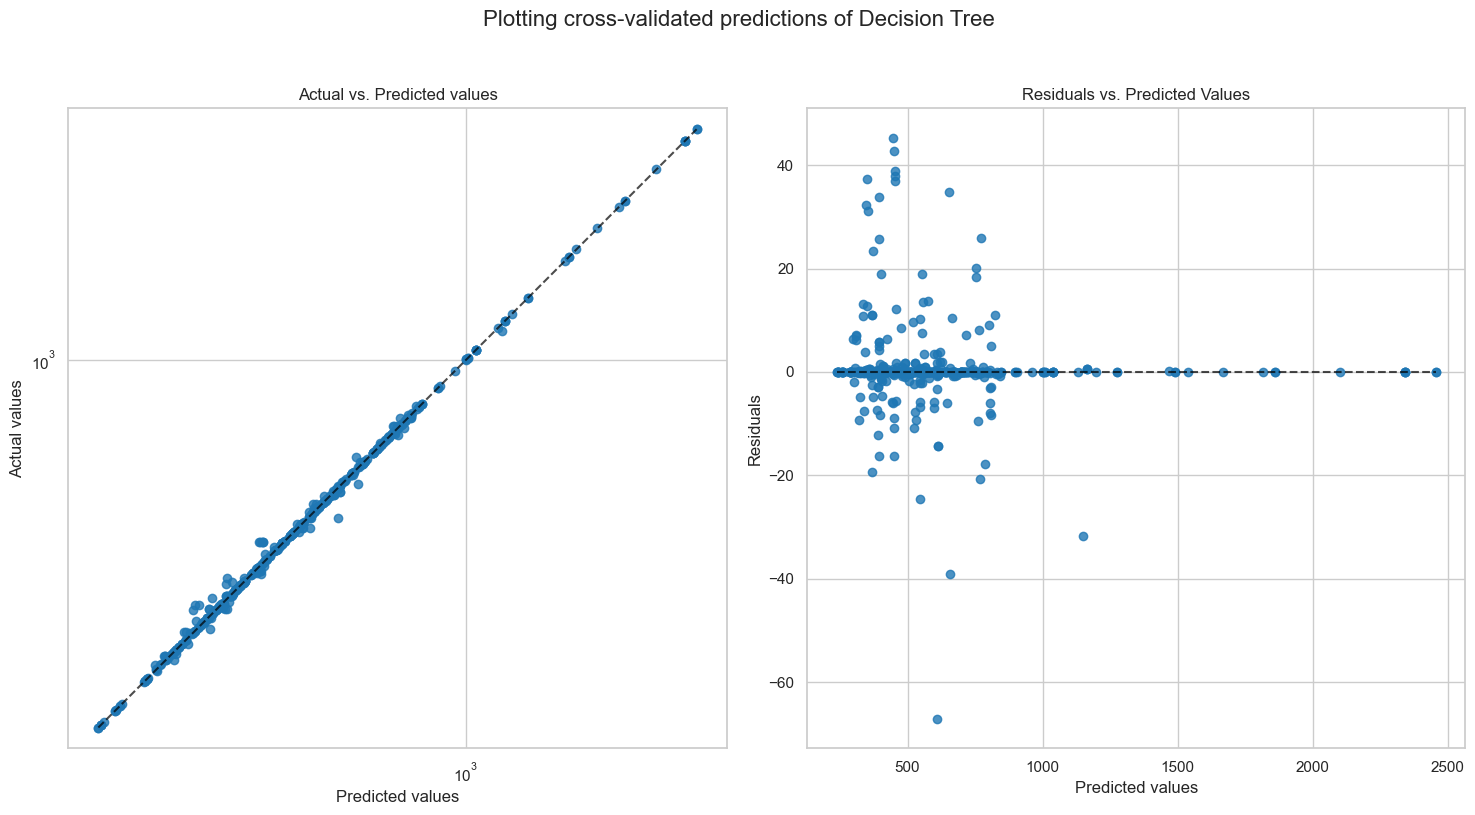

The mean residual of Decision Tree is: 0.34154291473159504


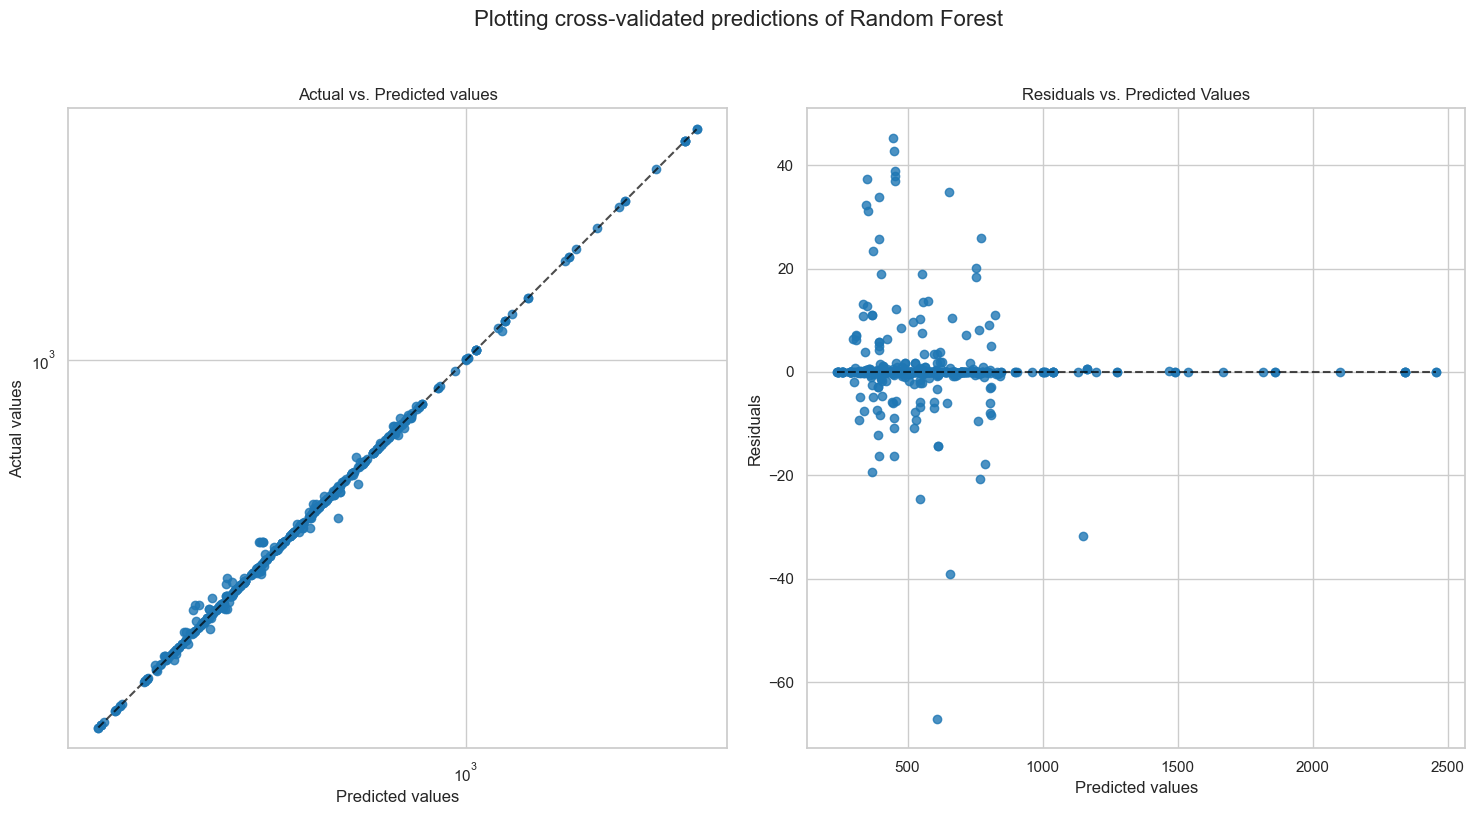

The mean residual of Random Forest is: 0.34154291473159504


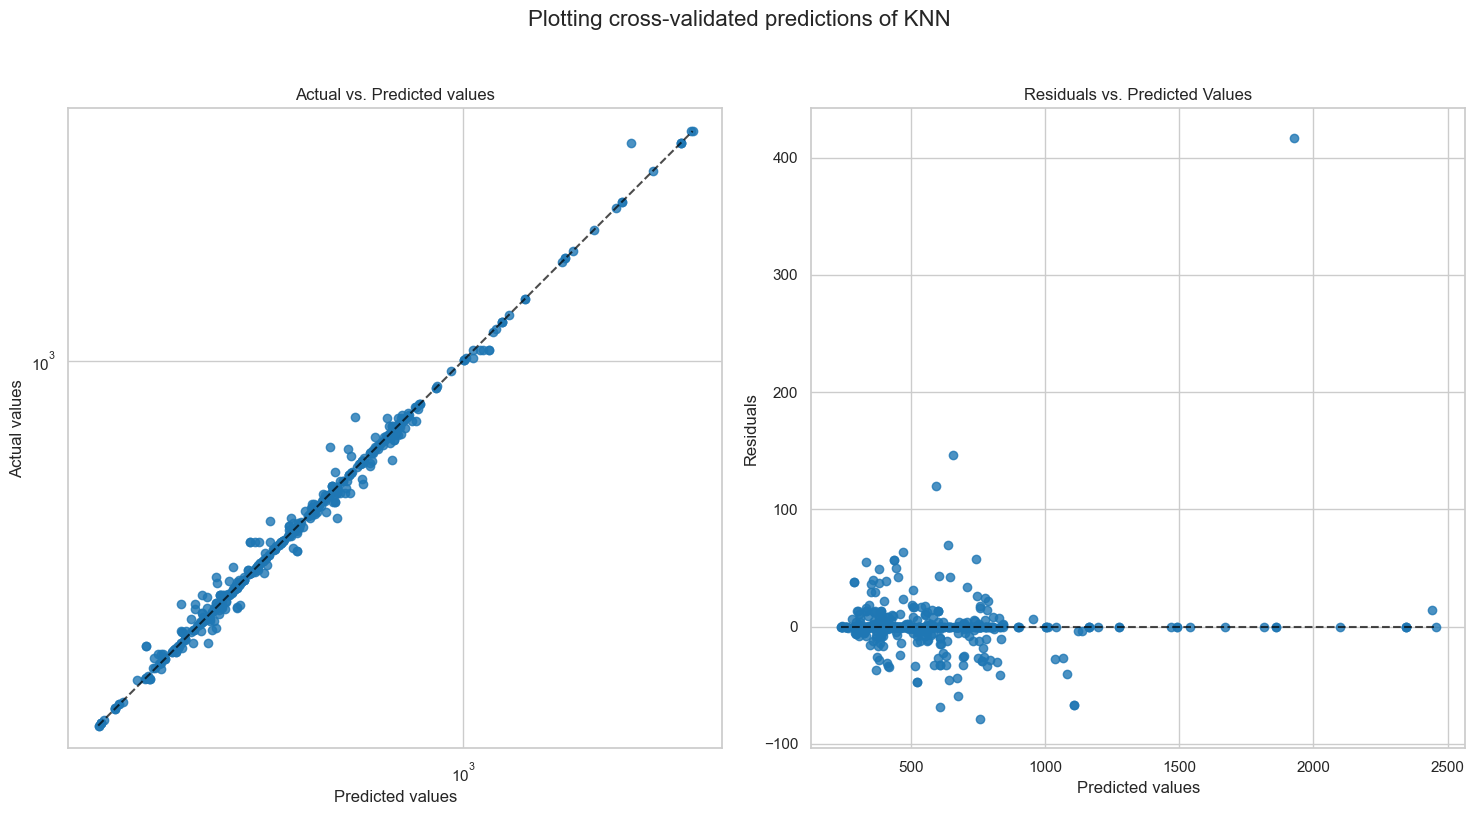

The mean residual of KNN is: 0.5250143798681322


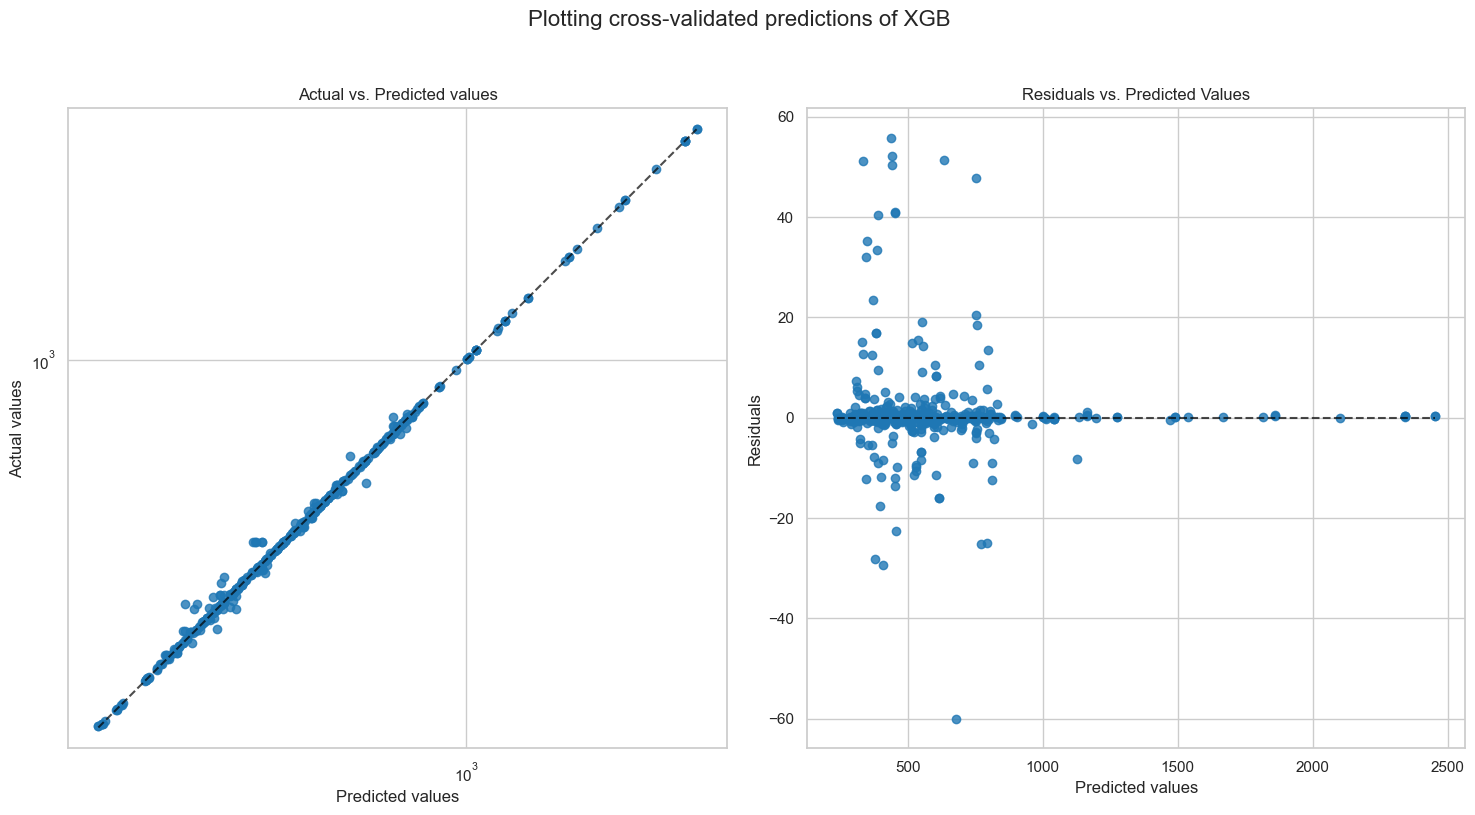

The mean residual of XGB is: 0.5234263113778959


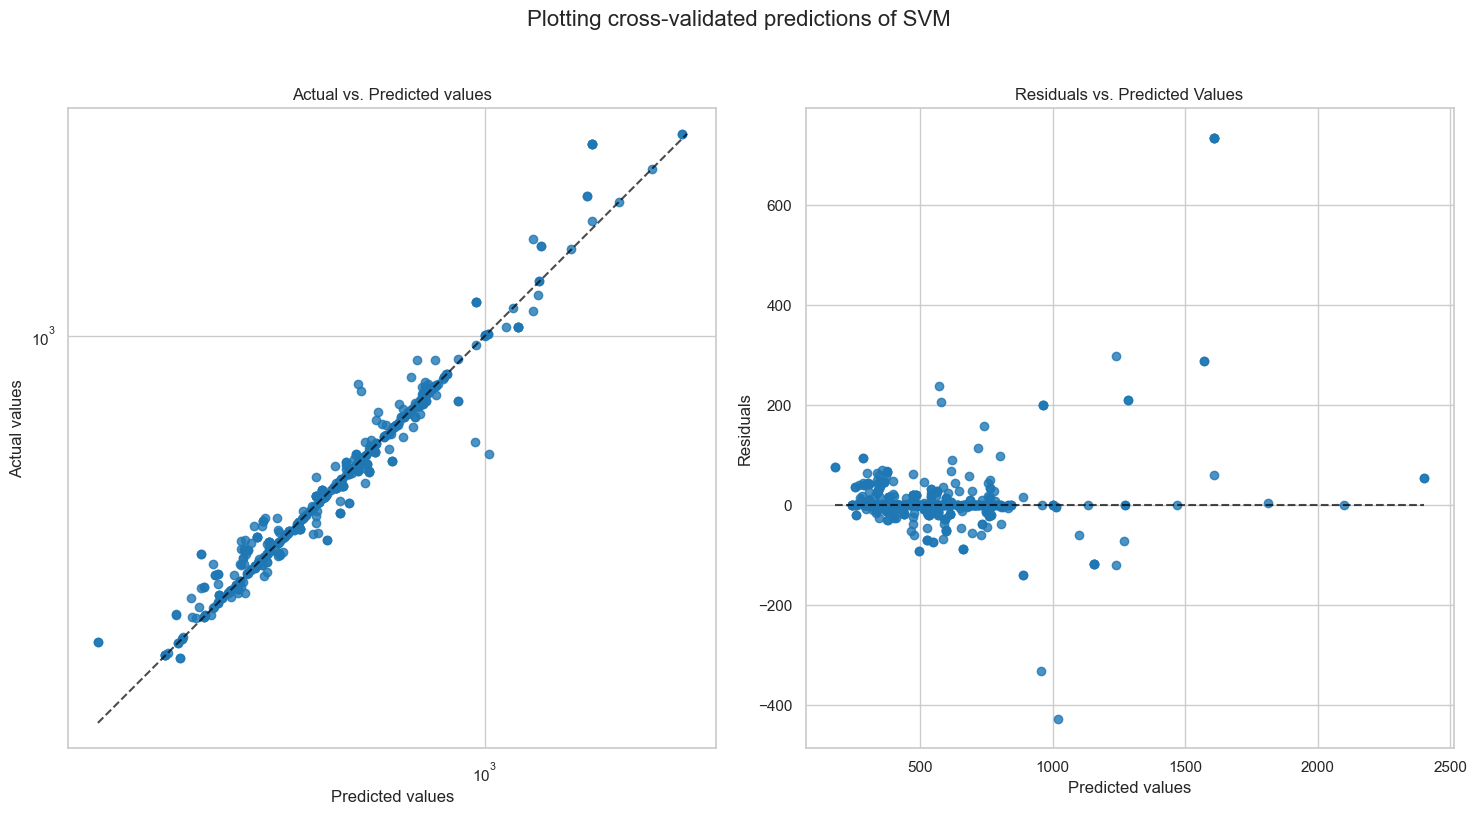

The mean residual of SVM is: 6.968869180095573


In [47]:

def plotPvA(model, name, X, y):
    y_pred = model.predict(X)
    fig, axs = plt.subplots(ncols=2, figsize=(15, 8))

    # Increase default font size
    plt.rcParams.update({'font.size': 14})

    # Define the prediction error display for actual vs. predicted
    pred_err_disp1 = PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=500,
        ax=axs[0],
        random_state=SEED,
    )

    # Add gridlines, labels and title
    axs[0].grid(True)
    axs[0].set_xlabel('Predicted values')
    axs[0].set_ylabel('Actual values')
    axs[0].set_title("Actual vs. Predicted values")

    # Set the axis scale to log
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # Define the prediction error display for residuals vs. predicted
    pred_err_disp2 = PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=500,
        ax=axs[1],
        random_state=SEED,
    )

    # Add gridlines, labels and title
    axs[1].grid(True)
    axs[1].set_xlabel('Predicted values')
    axs[1].set_ylabel('Residuals')
    axs[1].set_title("Residuals vs. Predicted Values")


    # Set the main title and layout
    fig.suptitle(f"Plotting cross-validated predictions of {name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    residuals = (y - y_pred)
    print(f"The mean residual of {name} is:", np.mean(residuals))

plotPvA(decisionTree_final, "Decision Tree", X_test, y_test)
plotPvA(randomForest_final, "Random Forest", X_test, y_test)
plotPvA(knn_final, "KNN", X_test, y_test)
plotPvA(xgb_final, "XGB", X_test, y_test)
plotPvA(svm_final, "SVM", X_test, y_test)

### Histogram of residuals
This plot can be used to check if the residuals are normally distributed, which is an assumption of many regression models. If the residuals are not normally distributed, it suggests that your model is not correctly capturing the data's patterns.

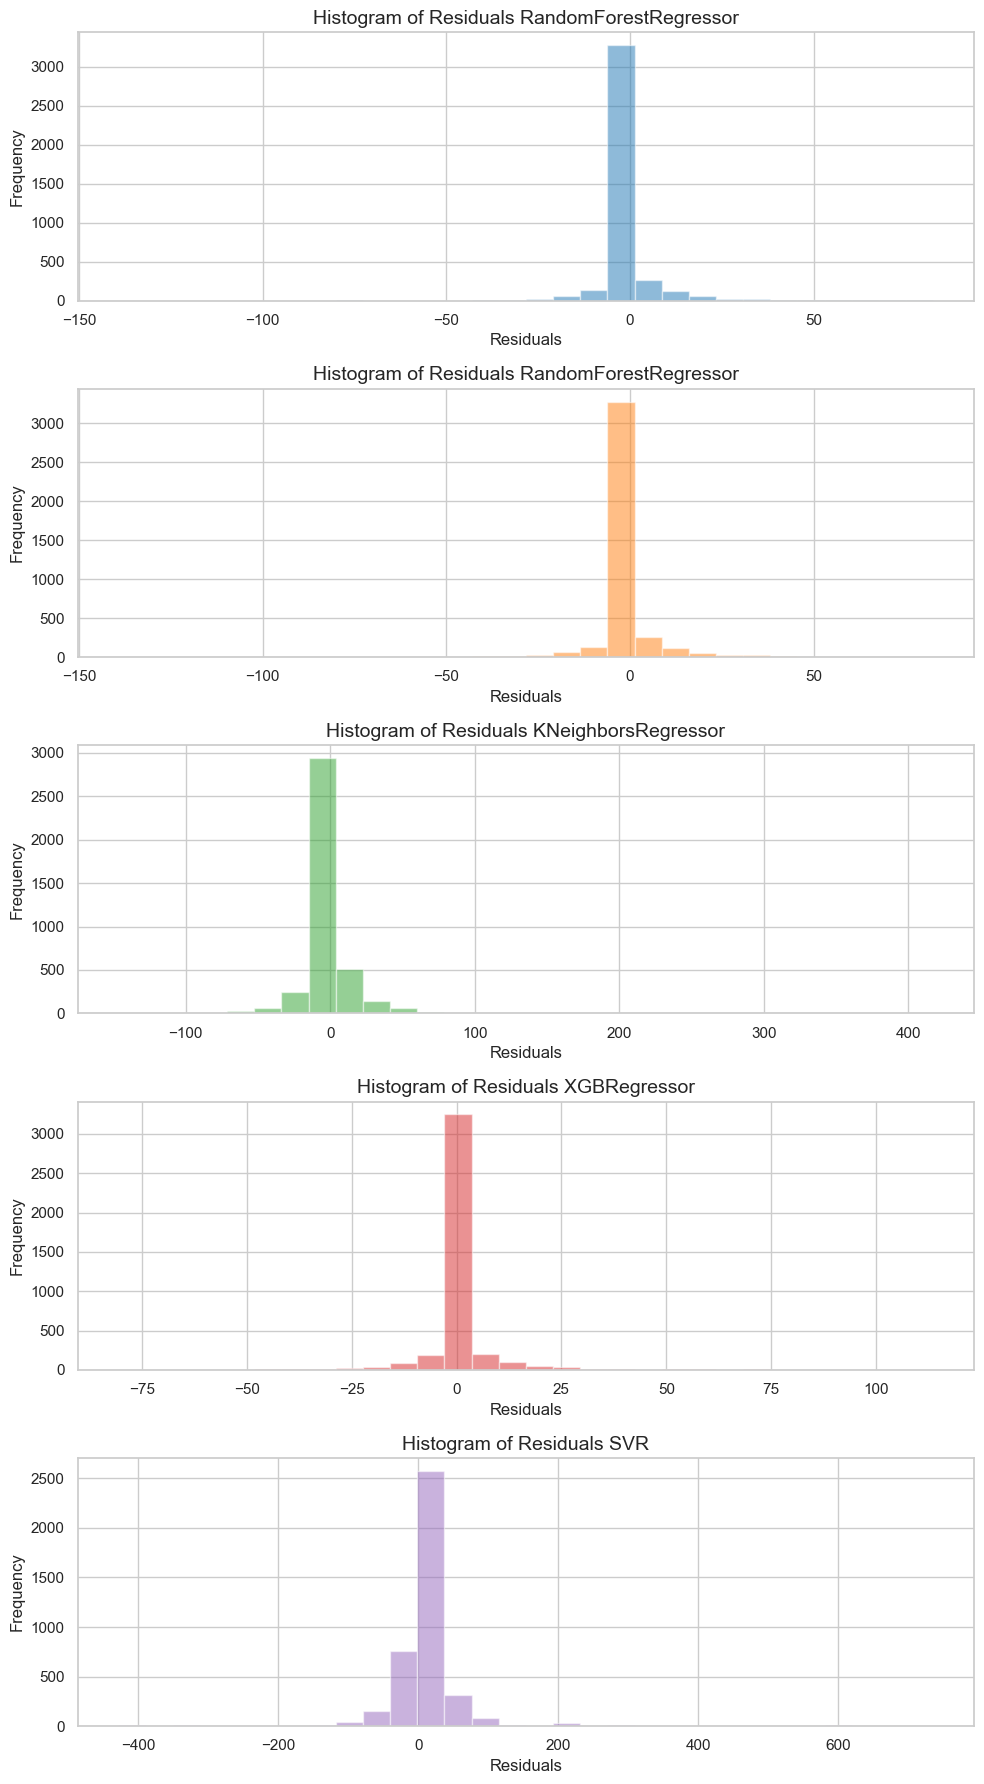

In [67]:
def plotResiduals(models,X,y):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd', '#8c564b']
# Obtain the predictions of the models
    predictions =[]
    residuals=[]
    for model in models:
        #compute predictions
        prediction = model.predict(X)
        predictions.append(prediction)
        #append residuals
        residuals.append(y - prediction)

    fig, axs = plt.subplots(len(models), 1, figsize=(10, 18))

    for i,model in enumerate(models):
        axs[i].hist(residuals[i], bins=30, color=colors[i], alpha=0.5)
        axs[i].set_title(f'Histogram of Residuals {model.steps[-1][1].__class__.__name__}', fontsize=14)
        axs[i].set_xlabel('Residuals', fontsize=12)
        axs[i].set_ylabel('Frequency', fontsize=12)

    fig.tight_layout()
    plt.show()

models=[decisionTree_final, randomForest_final, knn_final, xgb_final, svm_final]

plotResiduals(models,X_test,y_test)

## Performance on out of sample Dataset

### Metrics

In [ ]:
X_osample = df_osample.drop(TARGET_name,axis=1)
y_osample = df_osample[TARGET_name]

In [ ]:
def getMetrics(model,name, X,y):
    metrics = evaluate(model, X, y)

    return(pd.DataFrame({name:metrics}))

decisionTree_osample_metrics = getMetrics(decisionTree_final, "Decision Tree out of sample", X_osample, y_osample)
randomForest_osample_metrics = getMetrics(randomForest_final, "Random Forest out of sample", X_osample, y_osample)
knn_osample_metrics = getMetrics(knn_final, "KNN out of sample", X_osample, y_osample)
xgb_osample_metrics = getMetrics(xgb_final,"XGB out of sample", X_osample, y_osample)
svm_osample_metrics = getMetrics(svm_final,"SVM out of sample", X_osample, y_osample)

In [ ]:
osample_metrics = pd.concat([decisionTree_osample_metrics,
                            randomForest_osample_metrics,
                            knn_osample_metrics,
                            xgb_osample_metrics,
                            svm_osample_metrics],
                            axis=1)

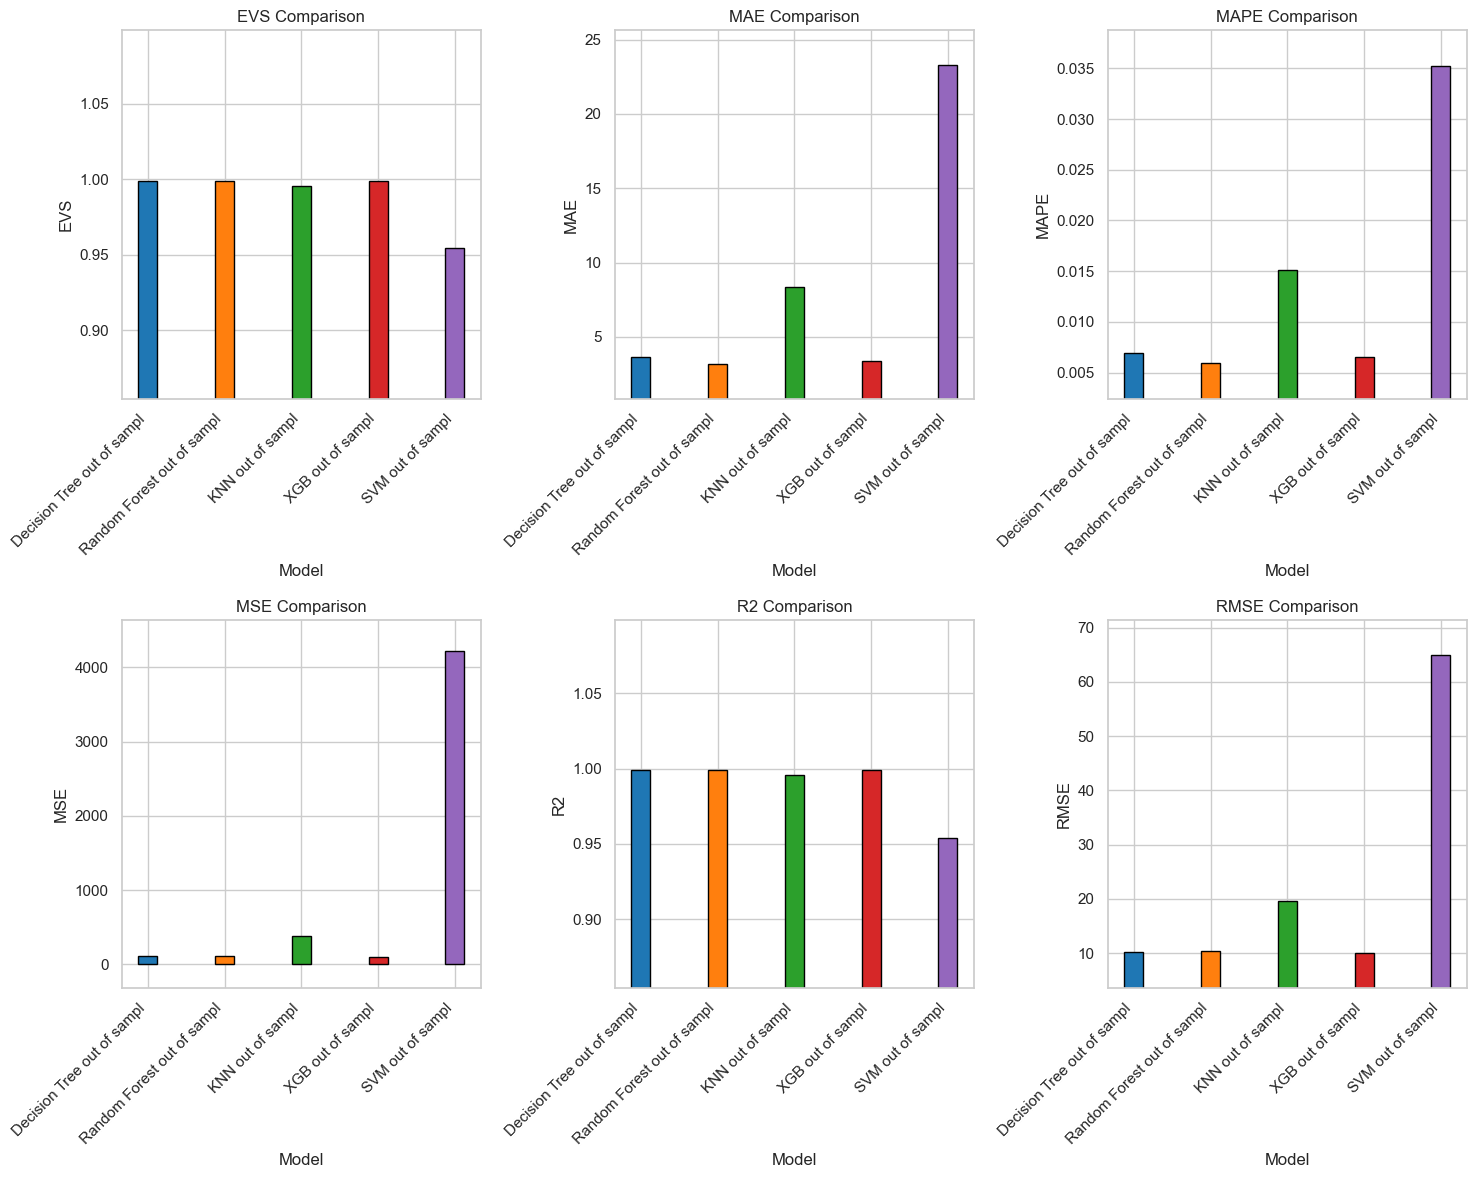

In [ ]:
plotBars(osample_metrics)

In [ ]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e']

# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = test_metrics.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(test_metrics.columns.str.replace(" Test",""), test_metrics.iloc[i], label="test", marker='o', color=colors[0])
    plt.plot(train_metrics.columns.str.replace(" Train",""), train_metrics.iloc[i], label="train", marker='o', color=colors[1])
    plt.plot(osample_metrics.columns.str.replace(" Train",""), osample_metrics.iloc[i], label="train", marker='o', color=colors[1])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


### Predicted vs actual plots
This is a scatter plot where the x-axis is the actual target values and the y-axis is the predicted values. If your model is perfectly accurate, all the points will lie along the line y = x (a 45-degree line). Deviations from this line indicate errors in prediction.

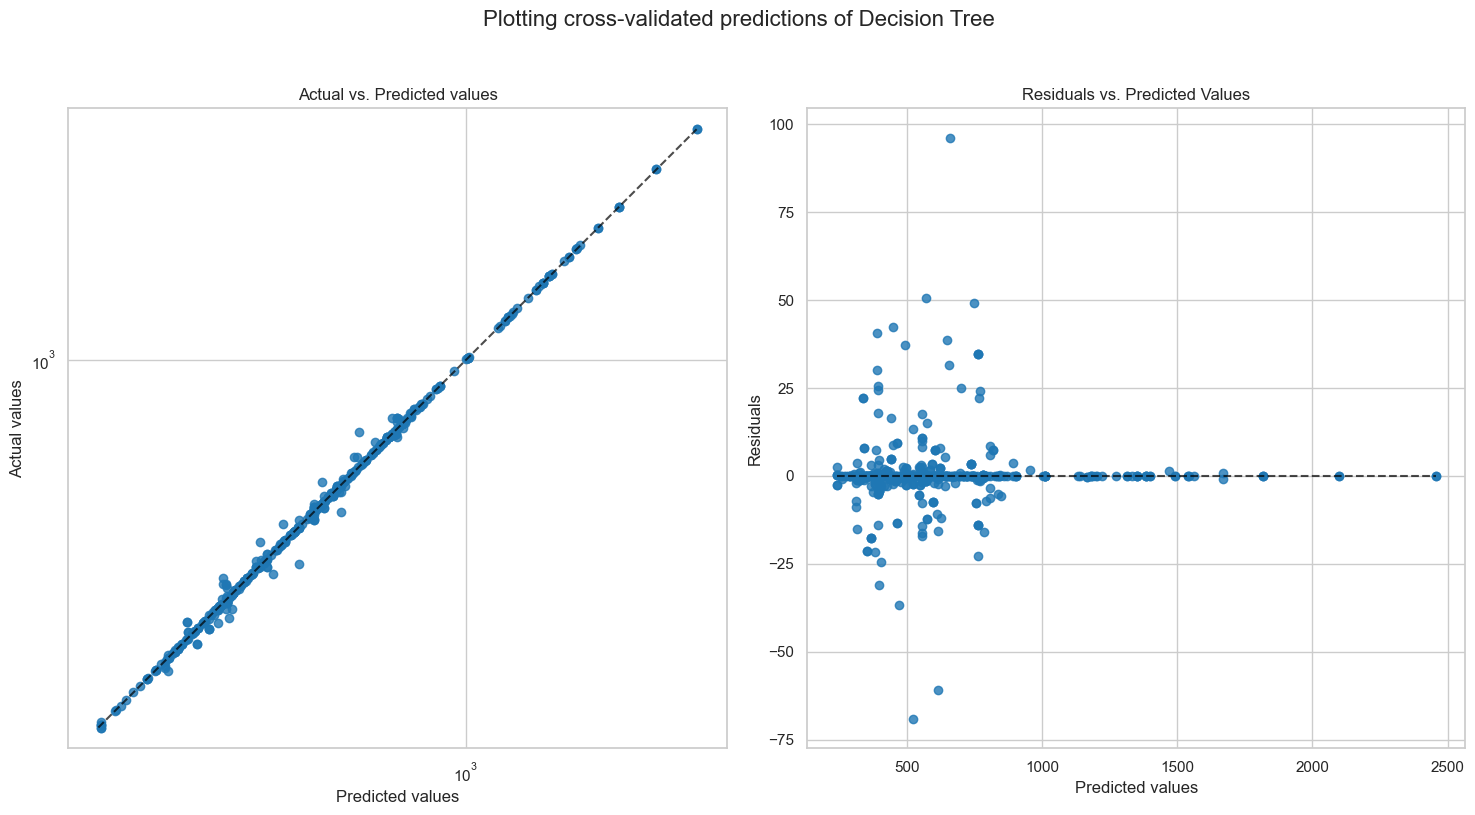

The mean residual of Decision Tree is: -0.13337499368690636


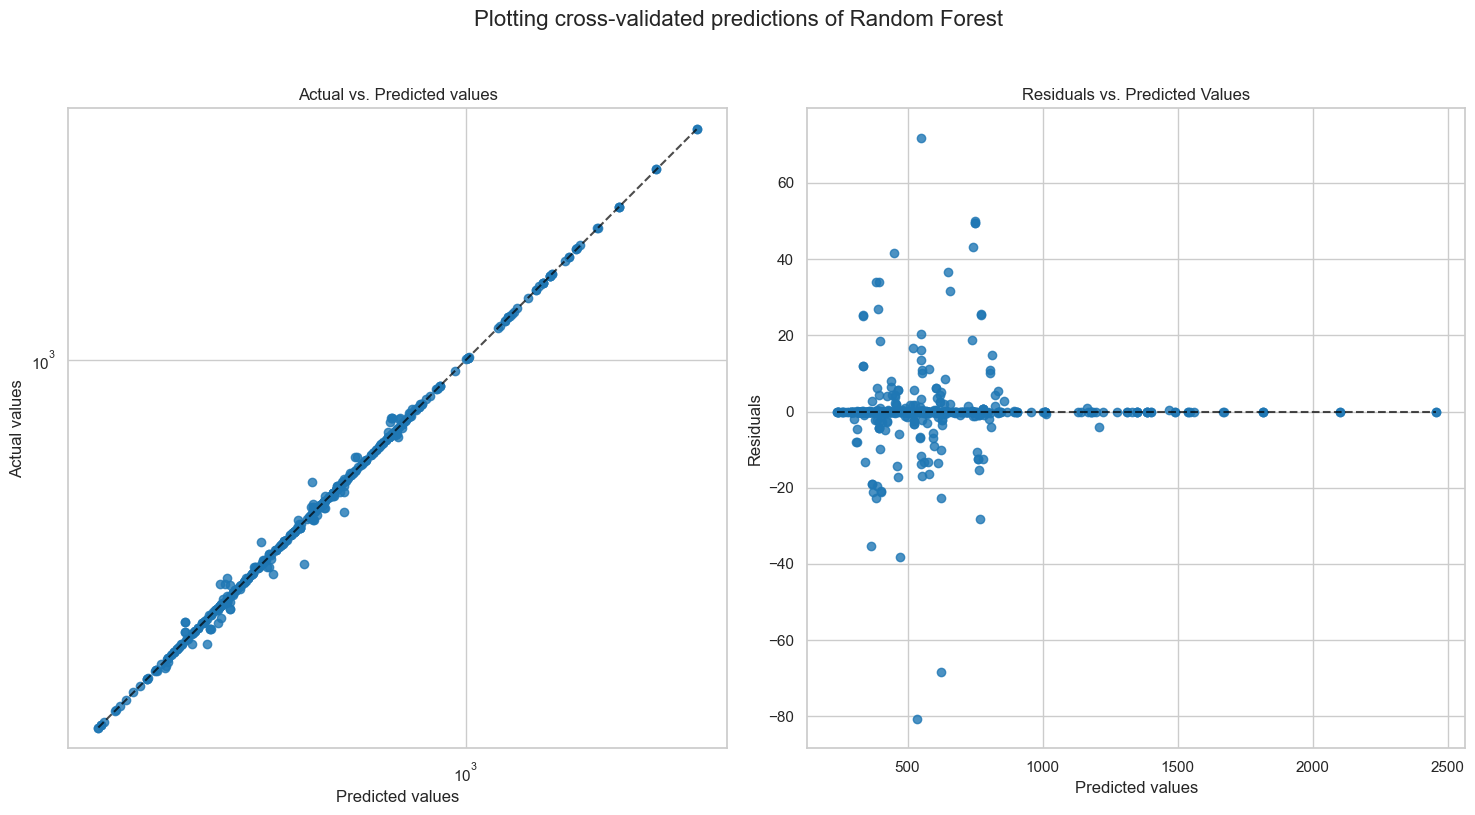

The mean residual of Random Forest is: -0.19127830240461902


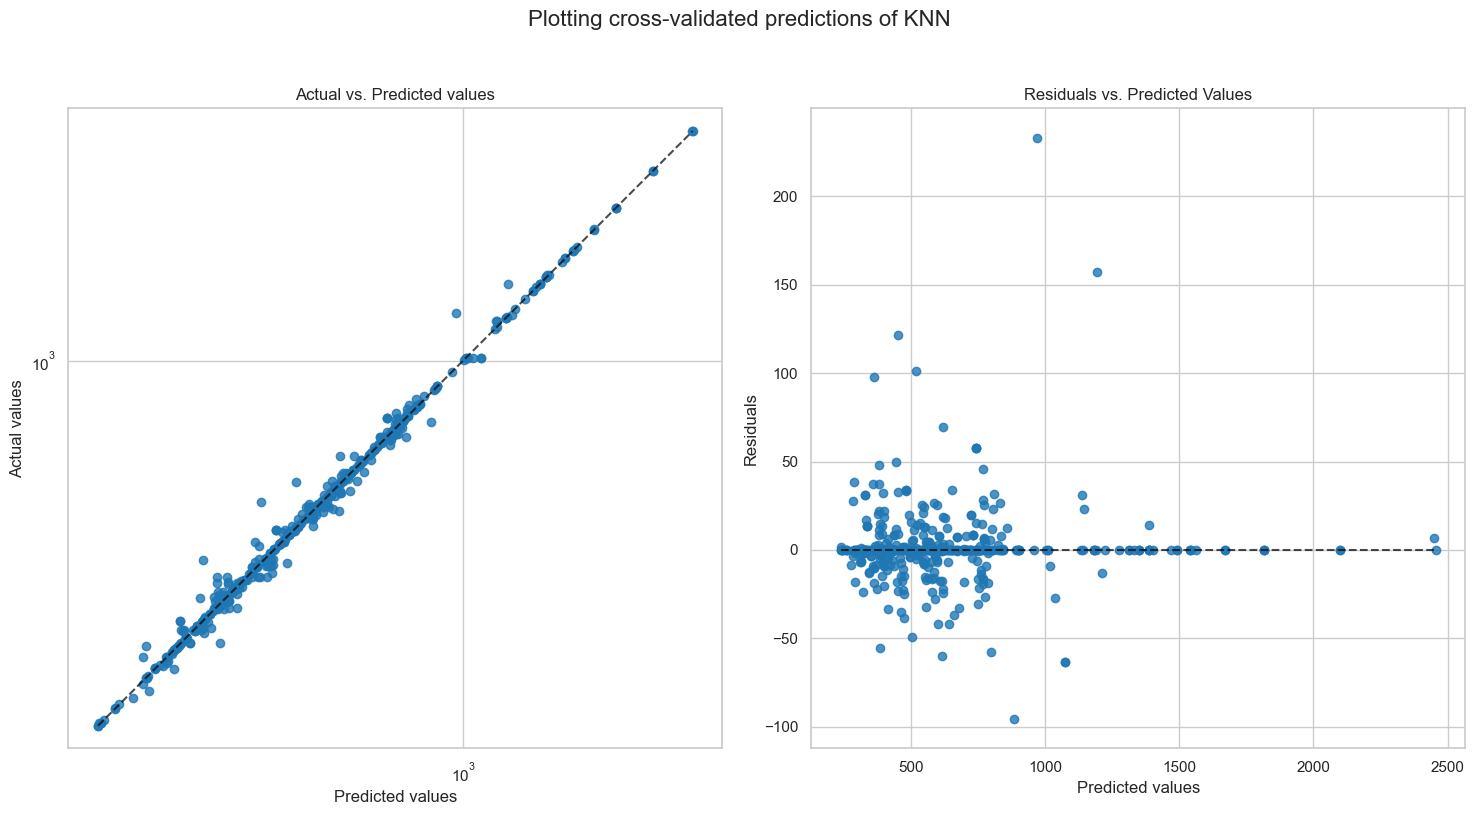

The mean residual of KNN is: -0.02357083677447351


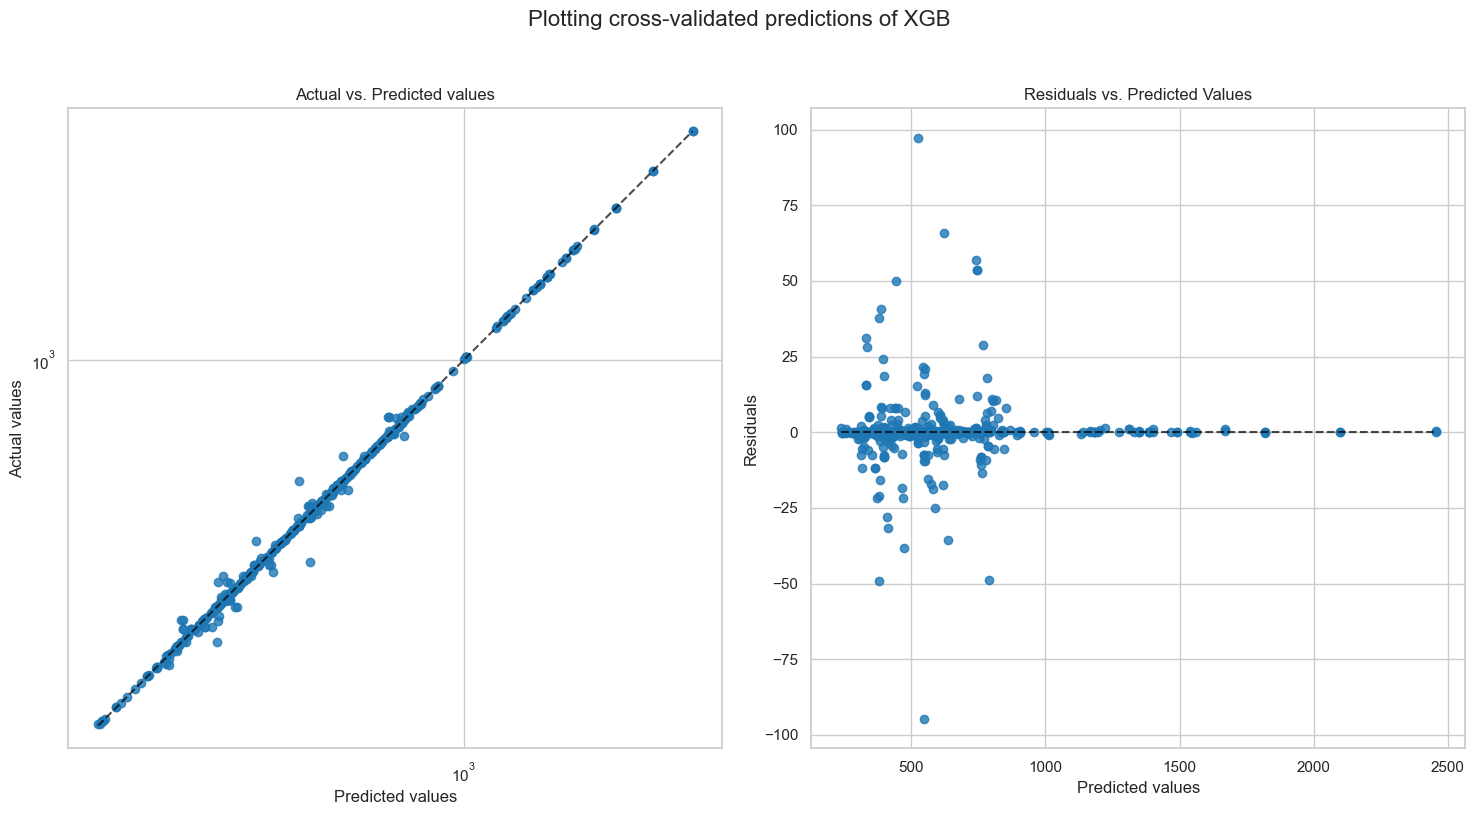

The mean residual of XGB is: 0.02394626542633804


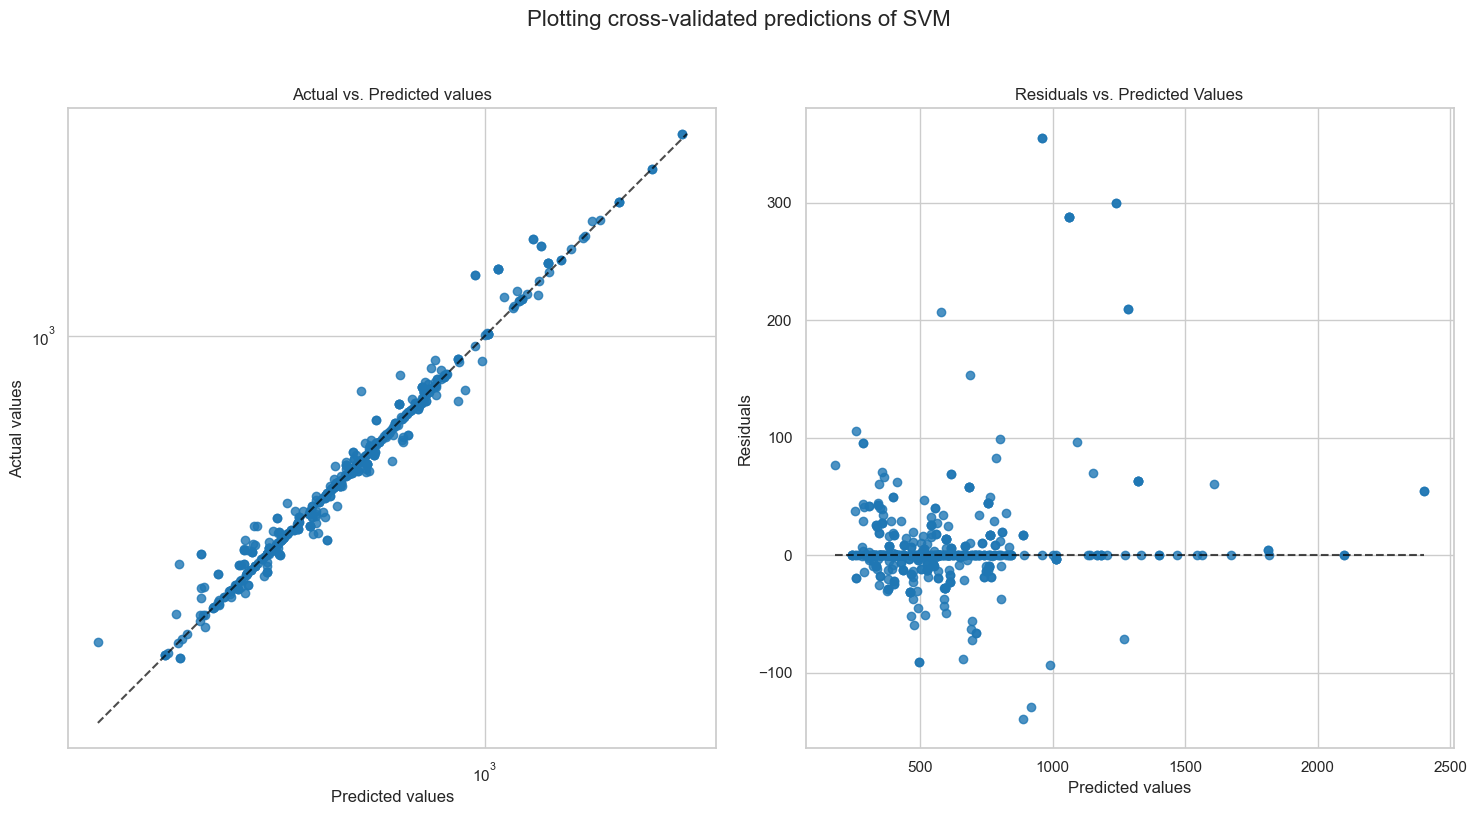

The mean residual of SVM is: 5.848141456100426


In [ ]:
plotPvA(decisionTree_final, "Decision Tree", X_osample, y_osample)
plotPvA(randomForest_final, "Random Forest", X_osample, y_osample)
plotPvA(knn_final, "KNN", X_osample, y_osample)
plotPvA(xgb_final, "XGB", X_osample, y_osample)
plotPvA(svm_final, "SVM", X_osample, y_osample)

### Histogram of residuals - Still to do!
This plot can be used to check if the residuals are normally distributed, which is an assumption of many regression models. If the residuals are not normally distributed, it suggests that your model is not correctly capturing the data's patterns.

In [49]:
plotResiduals(models, X_osample, y_osample)

NameError: name 'X_osample' is not defined

### Still to do for: Random Forest, KNN, SVM and XGboost (couldn't run the models)

## Feature Importance Analysis

### Helper functions

In [ ]:
def shapExplain(model):
    if model in [decisionTree_final, randomForest_final, xgb_final]:
        explainer = shap.TreeExplainer(decisionTree_final.named_steps["regressor"])
    elif model in [knn_final, svm_final]:
        explainer = shap.KernelExplainer(decisionTree_final.named_steps["regressor"])
    else:
        raise ValueError("Unsupported model type.")
    observations = model.named_steps["preprocessor"].transform(X_train)
    shap_values = explainer.shap_values(observations)
    shap.initjs()
    shap.summary_plot(shap_values, features=observations, feature_names=list(columns_pipeline), show = False)
    plt.show()
    return shap_values

In [ ]:
def importance(values):
    X_train_processed = pd.DataFrame(preprocessor.fit_transform(X_train), columns=columns_pipeline)
    shap_values_abs = np.abs(values)
    summary_df = pd.DataFrame([X_train_processed.columns, shap_values_abs.mean(axis=0)]).T
    summary_df.columns = ['Feature', 'mean_SHAP']
    summary_df['mean_SHAP'] = summary_df['mean_SHAP'].astype(float)
    mapping = pd.DataFrame(summary_df.groupby(summary_df['Feature'].str[0:5])['mean_SHAP'].mean()).reset_index() #!WICHTIG ANSCHAUEN: When you set str[0:10] or str[0:6], you are modifying the code to extract a different number of characters from the 'Feature' column. The resulting number of groups in the 'mapping' DataFrame will depend on the number of unique values obtained after extracting the specified characters 
    dic_to_replace = {'horse': "horsepower", 'brand': "brands",
                  'consu': 'consumption', 'model': 'model', 'milag': 'milage',
                  'regis': 'registration', 'durat': 'duration', 'fuel_': 'fuel_type', 'gear_':'gear_type', 'emiss': 'emission'}

    mapping = mapping.replace({"Feature": dic_to_replace})
    mapping = mapping.sort_values('mean_SHAP', ascending = False)
    mapping

    ## Adjust plot properly!
    height = mapping['mean_SHAP'].values
    bars = mapping['Feature'].to_list()
    y_pos = np.arange(len(bars))
    
    # Create horizontal bars
    plt.barh(y_pos, height, color=['dodgerblue'])
    
    # Create names on the x-axis
    plt.yticks(y_pos, bars)
    plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize = 13, labelpad = 15)
    plt.grid(axis='both', alpha=.3)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(1.0)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(1.0)
    plt.savefig('shap_values_mean.png', dpi = 100, bbox_inches='tight')
    plt.show()

### Decision tree

This plot provides an overview of the feature importance by showing the distribution of SHAP values for each feature

In [ ]:
shap_values_xgb = shapExplain(xgb_final)

NameError: name 'shapExplain' is not defined

#### Average importance of each variable

In [ ]:
importance(shap_values_xgb)

NameError: name 'importance' is not defined

In [ ]:
#!pip install --upgrade numpy==1.23.5

  Using cached numpy-1.23.5-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0


### Random Forest

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


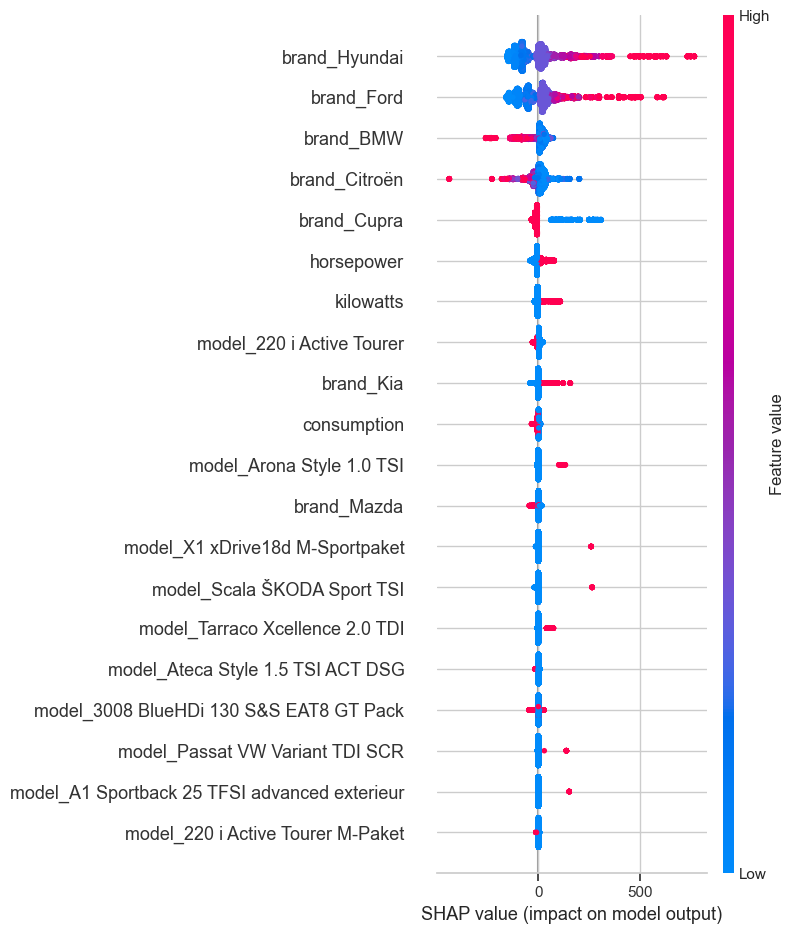

In [ ]:
shap_values_randomForest = shapExplain(randomForest_final)

#### Average importance of each variable

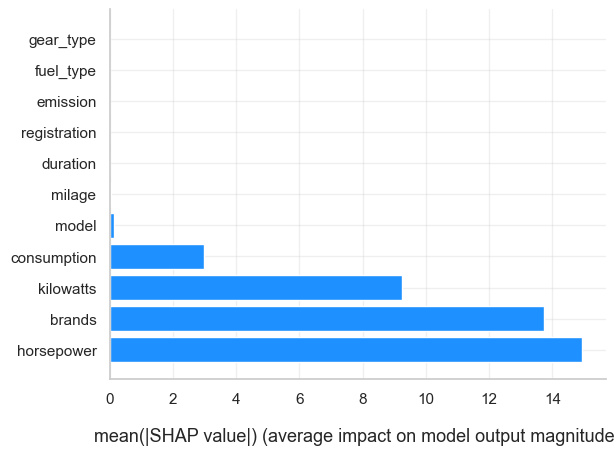

In [ ]:
importance(shap_values_decisionTree)

## Building light models accoring to feature selection

In [ ]:
X_train = X_train.drop("model")
X_test = X_test.drop("model")
X_osample = X_osample.drop("model")

### Best two models

#### Random Forest

In [ ]:
if compute:
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ])

    param_dist = {
        'regressor__n_estimators': randint(20,50),
        # 'regressor__max_depth': randint(1,7),
        'regressor__min_samples_split': randint(2, 30),
        'regressor__min_samples_leaf': randint(1, 100)
    }

    rf_randomized_search = RandomizedSearchCV(
        rf_pipeline, 
        param_distributions=param_dist, 
        n_iter = 2*iterations, 
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        n_jobs = -1)

    rf_randomized_search.fit(X_train, y_train)

    # evaluation metrics
    train_metrics = evaluate(rf_randomized_search, X_train, y_train)
    test_metrics = evaluate(rf_randomized_search, X_test, y_test)

    # create a dataframe from metrics
    randomForest_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(randomForest_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = rf_randomized_search.best_params_

    randomForest_params = pd.DataFrame({"Parameters": best_params})
    print(randomForest_params)



In [ ]:
if compute:
    finalForest_light = RandomForestRegressor(
        n_estimators = best_params['regressor__n_estimators'],
        min_samples_split = best_params['regressor__min_samples_split'],
        min_samples_leaf = best_params['regressor__min_samples_leaf']
    )

    randomForest_light_final = Pipeline([
        ("preprocessor", preprocessor),
        # Decision tree regression model
        ("regressor", finalForest_light)
    ])
    randomForest_light_final.fit(X_train, y_train)

else:
    randomForest_light_final = load(f'{modelfolder}/RandomForestRegressor.joblib')

train_metrics = evaluate(randomForest_light_final, X_train, y_train)
test_metrics = evaluate(randomForest_light_final, X_test, y_test)

# create a dataframe from metrics
randomForest_light_metrics = pd.DataFrame({'Random Forest Train':train_metrics, 'Random Forest Test': test_metrics})

print("\nEvaluation Metrics:")
print(randomForest_light_metrics)


Evaluation Metrics:
      Random Forest Train  Random Forest Test
MSE             37.251613           74.095298
RMSE             6.103410            8.607863
MAE              2.107848            2.990922
R2               0.999597            0.999201
EVS              0.999597            0.999202
MAPE             0.003967            0.005743


#### XGB

In [4]:
if compute:
    # Define the parameter distribution
    param_dist = {
        'regressor__max_depth': randint(3, 200),
        'regressor__learning_rate': [0.001, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
        'regressor__n_estimators': randint(100, 500),
        'regressor__gamma': [0.001,  0.01, 0.1, 0.2 , 0.3, 0.4, 0.50],
        'regressor__subsample': [0.5, 0.7, 0.8, 0.9],
        'regressor__colsample_bytree': [0.3, 0.5, 0.7, 0.8, 0.9],
    }

    # Create a new pipeline with the XGBoost regressor model
    xgb_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor())
    ])

    # Perform randomized search with cross-validation
    xgb_randomized_search = RandomizedSearchCV(
        xgb_pipeline,
        param_dist,
        n_iter=iterations,
        cv=crossvals,
        scoring=scoring,
        refit='MSE',
        return_train_score=True,
        random_state=SEED,
        error_score="raise",
        n_jobs=-1)
        
    xgb_randomized_search.fit(X_train, y_train)

    # Evaluation metrics
    train_metrics = evaluate(xgb_randomized_search, X_train, y_train)
    test_metrics = evaluate(xgb_randomized_search, X_test, y_test)

    # Create a DataFrame from metrics
    xgb_rand_metrics = pd.DataFrame({'Train Set': train_metrics, 'Test Set': test_metrics})

    print("\nEvaluation Metrics:")
    print(xgb_rand_metrics)

    # Get the best hyperparameter values and model performance
    best_params = xgb_randomized_search.best_params_
    xgb_params = pd.DataFrame({"Parameters": best_params})
    print(xgb_params)

NameError: name 'X_train' is not defined

In [ ]:
if compute:
    finalXGB_light = XGBRegressor(
        colsample_bytree = best_params['regressor__colsample_bytree'],
        gamma = best_params['regressor__gamma'],
        learning_rate = best_params['regressor__learning_rate'],
        max_depth = best_params['regressor__max_depth'],
        subsample = best_params['regressor__subsample']
    )

    xgb_light_final = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", finalXGB_light)
    ])
    xgb_light_final.fit(X_train, y_train)

else:
    xgb_light_final = load(f'{modelfolder}/XGBRegressor.joblib')

train_metrics = evaluate(xgb_light_final, X_train, y_train)
test_metrics = evaluate(xgb_light_final, X_test, y_test)

# Create a DataFrame from metrics
xgb_light_metrics = pd.DataFrame({'XGB Train': train_metrics, 'XGB Test': test_metrics})

print("\nEvaluation Metrics:")
print(xgb_light_metrics)


Evaluation Metrics:
      XGB Train   XGB Test
MSE   12.967564  83.684338
RMSE   3.601050   9.147914
MAE    1.109263   3.320201
R2     0.999860   0.999098
EVS    0.999860   0.999101
MAPE   0.002158   0.006516


### Performance comparison

In [ ]:
randomForest_light_osample_metrics = getMetrics(randomForest_final, "Random Forest out of sample", X_osample, y_osample)
xgb_light_osample_metrics = getMetrics(xgb_final,"XGB out of sample", X_osample, y_osample)

In [ ]:
metrics = [randomForest_light_osample_metrics, xgb_light_osample_metrics]

# Create empty DataFrames for train metrics and test metrics
train_metrics = pd.DataFrame()
test_metrics = pd.DataFrame()

# Loop through the metrics list and assign train and test metrics to respective DataFrames
for metric in metrics:
    for col in metric.columns:
        if "Train" in col:
            train_metrics = pd.concat([train_metrics, metric[[col]]], axis=1)
        elif "Test" in col:
            test_metrics = pd.concat([test_metrics, metric[[col]]], axis=1)

In [ ]:
osample_metrics = pd.concat([randomForest_light_osample_metrics,
                            xgb_light_osample_metrics],
                            axis=1)

In [ ]:
# Set the style and color palette of the plot
sns.set(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e']

# Set the figure size
plt.figure(figsize=(12, 12))

# Plot the evaluation metrics
metrics = test_metrics.index
metrics1 = ['MSE', 'RMSE', 'MAE', 'R2', 'EVS', 'MAPE']

for i in range(len(metrics)):
    plt.subplot(3, 2, i+1)
    plt.plot(test_metrics.columns.str.replace(" Test",""), test_metrics.iloc[i], label="test", marker='o', color=colors[0])
    plt.plot(train_metrics.columns.str.replace(" Train",""), train_metrics.iloc[i], label="train", marker='o', color=colors[1])
    plt.plot(osample_metrics.columns.str.replace(" Train",""), osample_metrics.iloc[i], label="train", marker='o', color=colors[1])

    # Set the y-axis label
    plt.ylabel(metrics[i])
    
    # Set the title of the plot
    title =metrics[i]
    plt.title(title+ " of the different models")
    
    # Set the legend
    plt.legend()


# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
plotPvA(randomForest_final, "Random Forest", X_osample, y_osample)
plotPvA(randomForest_light_final, "Random Forest light", X_osample, y_osample)

plotPvA(xgb_final, "XGB", X_osample, y_osample)
plotPvA(xgb_light_final, "XGB light", X_osample, y_osample)

## Safe models using joblib


In [71]:
# Specify the file path where you want to save the model

folder='models/test'
models_to_safe = [decisionTree_final, randomForest_final, knn_final, xgb_final, svm_final]

def safeModel(models, folder):
    os.makedirs(folder, exist_ok=True)  # Create directory if it doesn't exist
    for model in models:
        path = folder+f'/{model.steps[-1][1].__class__.__name__}.joblib'
        #with open(path, 'wb') as f:
        dump(model, path) 


In [72]:
safeModel(models,folder)

## Check Scikit-learn and python version

In [36]:
import sklearn
sklearn.__version__
if(sklearn.__version__!="1.2.2"):
    try:
        !pip install --upgrade numpy
        !pip install --upgrade pandas
        !pip install --upgrade scikit-learn
    except:
        print("Check your Python version. Has to be >3.8!")
        import sys
        print(sys.version)
